In [1]:
# !python3 -m pip install tensorflow
# !pip install tf-keras
!pip install transformers
# !pip install torch
!pip install pandas
!pip install -U scikit-learn
!pip install matplotlib
!pip install nltk
!pip install seaborn
!pip install ipywidgets


In [ ]:
!pip3 install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu118


Looking in indexes: https://download.pytorch.org/whl/cu118


In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_log_error
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
# from transformers import BertTokenizer, TFBertModel
import matplotlib.pyplot as plt


# Load the data
# train = pd.read_csv('/Users/dkamboj6/Recitation/ECE-461P-Term-Project/mercari-price-suggestion-challenge/train.tsv',  delimiter='\t')


# test = pd.read_csv('/Users/dkamboj6/Recitation/ECE-461P-Term-Project/mercari-price-suggestion-challenge/test.tsv', delimiter='\t')

train= pd.read_csv('C:/Users/divya/OneDrive/Documents/UTAUSTIN/Semester 6/461p/ECE-461P-Term-Project/mercari-price-suggestion-challenge/train.tsv/train.tsv',delimiter='\t')
test=pd.read_csv('C:/Users/divya/OneDrive/Documents/UTAUSTIN/Semester 6/461p/ECE-461P-Term-Project/mercari-price-suggestion-challenge/test.tsv/test.tsv',delimiter='\t')

In [4]:
# Fill missing values

train.fillna('Unknown', inplace=True)
test.fillna('Unknown', inplace=True)


In [5]:
train.head()

train_id                                 name  item_condition_id  \
0         0  MLB Cincinnati Reds T Shirt Size XL                  3   
1         1     Razer BlackWidow Chroma Keyboard                  3   
2         2                       AVA-VIV Blouse                  1   
3         3                Leather Horse Statues                  1   
4         4                 24K GOLD plated rose                  1   

                                       category_name brand_name  price  \
0                                  Men/Tops/T-shirts    Unknown   10.0   
1  Electronics/Computers & Tablets/Components & P...      Razer   52.0   
2                        Women/Tops & Blouses/Blouse     Target   10.0   
3                 Home/Home Décor/Home Décor Accents    Unknown   35.0   
4                            Women/Jewelry/Necklaces    Unknown   44.0   

   shipping                                   item_description  
0         1                                 No description yet  
1         0  This keyboard is in great condition and works ...  
2         1  Adorable top with a hint of lace and a key hol...  
3         1  New with tags. Leather horses. Retail for [rm]...  
4         0          Complete with certificate of authenticity

In [6]:
train.info()
# name is not unique
# item_condition_id is {1, 2, 3, 4, 5}, where 1 is probably new and 5 is probably poor (see https://www.mercari.com/us/help_center/product-info/item-conditions/)
# category_name can be null (likely missing) or three increasingly specific categories (e.g. Women/Women's handbags/Backpacks); some category names have slashes in their name (e.g. iPad/tablet/ebook readers), but we might assume that this can only happen in the last category
# brand_name can be null or a brand listed on the website
# price is in USD and is the target we want to predict
# shipping is 1 if paid by seller, 0 if paid by buyer
# item_description can be null, have "No description yet", or be user specified; prices in description were replaced by "[rm]"

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1482535 entries, 0 to 1482534
Data columns (total 8 columns):
 #   Column             Non-Null Count    Dtype  
---  ------             --------------    -----  
 0   train_id           1482535 non-null  int64  
 1   name               1482535 non-null  object 
 2   item_condition_id  1482535 non-null  int64  
 3   category_name      1482535 non-null  object 
 4   brand_name         1482535 non-null  object 
 5   price              1482535 non-null  float64
 6   shipping           1482535 non-null  int64  
 7   item_description   1482535 non-null  object 
dtypes: float64(1), int64(3), object(4)
memory usage: 90.5+ MB


count    1.482535e+06
mean     2.673752e+01
std      3.858607e+01
min      0.000000e+00
25%      1.000000e+01
50%      1.700000e+01
75%      2.900000e+01
max      2.009000e+03
Name: price, dtype: float64

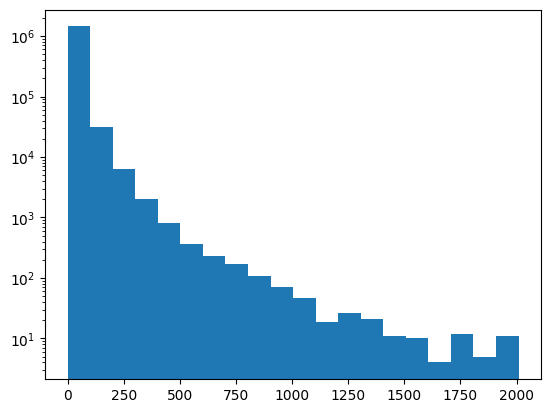

In [7]:
plt.hist(train['price'], bins=20, log=True)
train['price'].describe()

Bundle 2232 34.62275379144398
Reserved 453 39.31726243469863
Converse 445 8.93785554068539
BUNDLE 418 40.73660381368858
Dress 410 12.584195779698845
Coach purse 404 19.9839830958423
Lularoe TC leggings 396 11.648930570195231
Romper 353 6.250561396367981
Nike 340 16.975025290181176
Vans 334 9.939706023805332
American Eagle Jeans 325 8.244153011643599
Miss Me Jeans 284 12.928838593112092
Lularoe OS leggings 281 9.200133174695361
ON HOLD 274 45.127049274108344
Coach Purse 258 21.172202964856144


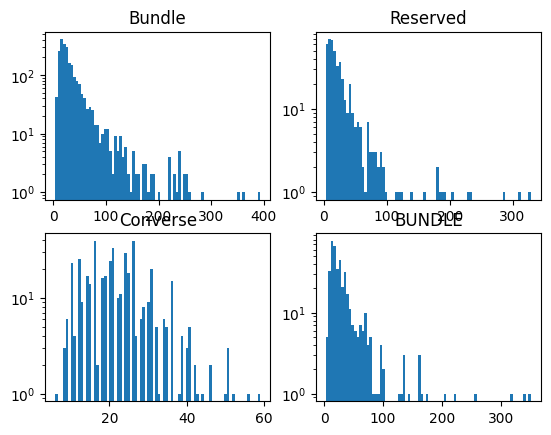

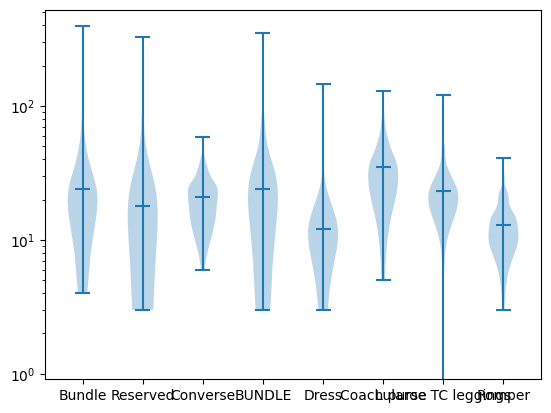

In [8]:
names = train['name'].value_counts()
# Many product listings have the same name, so we can check for prices
# A good amount of these "generic names" have high range / standard deviation in price

# Standard deviation
top_n = 15
for i in range(top_n):
    name = names.index[i]
    filtered_data = train[train['name'] == name]
    print(name, names.iat[i], filtered_data['price'].std())

# Histogram
rows = 2
cols = 2
fig, axs = plt.subplots(rows, cols)
for r in range(rows):
    for c in range(cols):
        name = names.index[r * cols + c]
        axs[r, c].set_title(name)
        axs[r, c].hist(train[train['name'] == name]['price'], bins=80, log=True)

# Violin
top_n = 8
prices_by_name = []
name_list = []
for i in range(top_n):
    name = names.index[i]
    filtered_data = train[train['name'] == name]
    prices_by_name.append(filtered_data['price'])
    name_list.append(name)

fig, ax = plt.subplots()
ax.violinplot(prices_by_name, showmedians=True)
ax.set_xticks(np.linspace(1, top_n, top_n), labels=name_list)
ax.set_yscale('log')

item_condition_id
1    640549
3    432161
2    375479
4     31962
5      2384
Name: count, dtype: int64



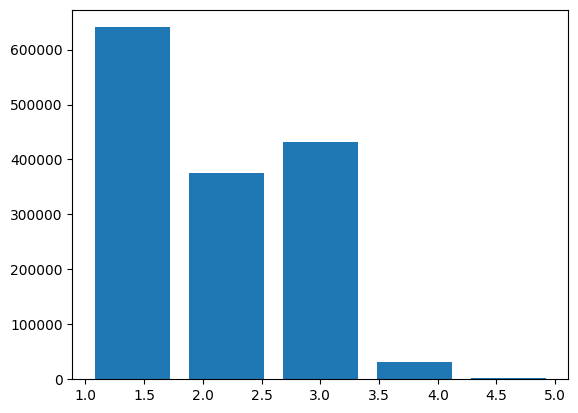

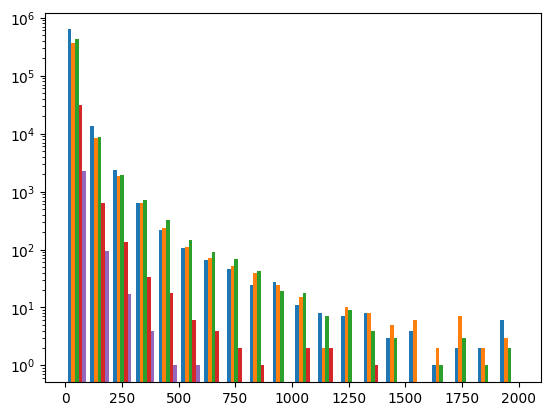

In [9]:
# Distribution of item condition
print(train['item_condition_id'].value_counts())
fig, ax = plt.subplots()
ax.hist(train['item_condition_id'], bins=5, rwidth=0.8)

# Histogram by item condition
item_condition_data = train.groupby(by='item_condition_id')
item_condition_partition = []
for i in item_condition_data.groups:
    item_condition_partition.append(item_condition_data.get_group(i)['price'])

fig, ax = plt.subplots()
ax.hist(item_condition_partition, bins=20, log=True)
print()

In [10]:
# Split category_name into three parts
category_splits = train['category_name'].str.split('/', n=2, expand=True)
category_splits.head(10)

0                    1                   2
0                     Men                 Tops            T-shirts
1             Electronics  Computers & Tablets  Components & Parts
2                   Women       Tops & Blouses              Blouse
3                    Home           Home Décor  Home Décor Accents
4                   Women              Jewelry           Necklaces
5                   Women                Other               Other
6                   Women             Swimwear           Two-Piece
7       Sports & Outdoors              Apparel               Girls
8       Sports & Outdoors              Apparel               Girls
9  Vintage & Collectibles         Collectibles                Doll

Stuff with category splits


In [11]:
category_splits.value_counts(sort=False)


0       1                 2                       
Beauty  Bath & Body       Bath                         5049
                          Bathing Accessories           332
                          Cleansers                     723
                          Other                         147
                          Scrubs & Body Treatments      812
                                                      ...  
Women   Women's Handbags  Messenger & Crossbody        8926
                          Other                        1116
                          Satchel                      2333
                          Shoulder Bag                15328
                          Totes & Shoppers             9373
Name: count, Length: 1287, dtype: int64

In [12]:
# Brand name is inherently categorical but can be null
print('brand_name is not null:')
print(train['brand_name'].value_counts())
print()
print('brand_name is null:')
print(train['brand_name'].isnull().value_counts())

brand_name is not null:
brand_name
Unknown                 632682
PINK                     54088
Nike                     54043
Victoria's Secret        48036
LuLaRoe                  31024
                         ...  
The Learning Journey         1
Pampers Baby Fresh           1
Huggies One & Done           1
Classic Media                1
Kids Only                    1
Name: count, Length: 4810, dtype: int64

brand_name is null:
brand_name
False    1482535
Name: count, dtype: int64


             count       mean       std  min   25%   50%   75%     max
shipping                                                              
0         819435.0  30.111778  39.53592  0.0  13.0  20.0  33.0  2009.0
1         663100.0  22.567726  36.95579  0.0   8.0  14.0  25.0  2000.0



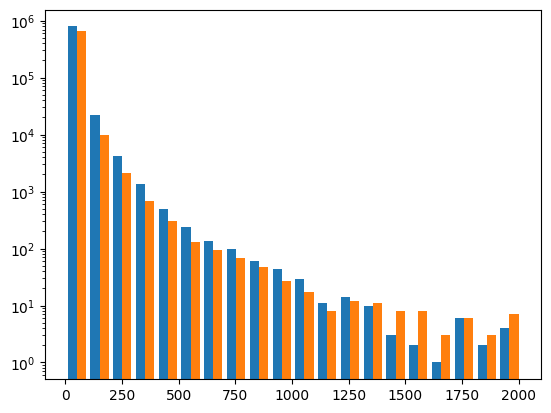

In [13]:
# Distribution of shipping (0=buyer, 1=seller)
shipping_data = train.groupby(by='shipping')
print(shipping_data['price'].describe())

shipping_partition = []
for i in shipping_data.groups:
    shipping_partition.append(shipping_data.get_group(i)['price'])

plt.hist(shipping_partition, bins=20, log=True)
print()

In [14]:
# Some item descriptions are repeated
description_data = train['item_description']

# Some items are missing a description
print('Item description is null:')
print(description_data.isnull().value_counts())
print()

# By far, the most common "description" is "No description yet"
# Other most common descriptions are just generic descriptions
description_rank = description_data.value_counts()
description_rank.head(100)

Item description is null:
item_description
False    1482535
Name: count, dtype: int64



item_description
No description yet      82489
New                      4099
Brand new                3058
Good condition           1274
Great condition          1158
                        ...  
Sealed                     96
Works great                96
Size 2                     94
Excellent condition!       93
All sizes                  91
Name: count, Length: 100, dtype: int64

In [15]:
# Some items mention a price in the description. They have been replaced by "[rm]"
rm_price_desc = train['item_description'].str.contains('[rm]', na=False, regex=False)
print(rm_price_desc.value_counts())

rm_price_desc = train[rm_price_desc]
rm_price_desc.head(10)

item_description
False    1348729
True      133806
Name: count, dtype: int64


train_id                                    name  item_condition_id  \
3           3                   Leather Horse Statues                  1   
7           7    Girls cheer and tumbling bundle of 7                  3   
10         10                         Smashbox primer                  2   
17         17     New: Baby K'tan active baby carrier                  1   
23         23                      Triple car charger                  1   
30         30  Too Faced Better Than Sex Mascara QTY3                  1   
67         67          H&M Women's Long Horse Sweater                  2   
72         72                  Listing for Aknuckles1                  1   
103       103                             kids adidas                  1   
119       119    Victoria's Secret PINK Zip Up Hoodie                  3   

                                         category_name           brand_name  \
3                   Home/Home Décor/Home Décor Accents              Unknown   
7                      Sports & Outdoors/Apparel/Girls                Soffe   
10                                  Beauty/Makeup/Face             Smashbox   
17                      Kids/Gear/Backpacks & Carriers              Unknown   
23   Electronics/Cell Phones & Accessories/Chargers...              Unknown   
30                                  Beauty/Makeup/Eyes            Too Faced   
67                             Women/Sweaters/Crewneck                  H&M   
72                      Home/Home Décor/Home Fragrance  Nostalgia Electrics   
103                              Kids/Boys 2T-5T/Shoes              Unknown   
119                            Women/Sweaters/Full Zip                 PINK   

     price  shipping                                   item_description  
3     35.0         1  New with tags. Leather horses. Retail for [rm]...  
7      6.0         1  You get three pairs of Sophie cheer shorts siz...  
10     8.0         1       0.25 oz Full size is 1oz for [rm] in Sephora  
17    29.0         1  Brand new in box Size: Medium Color: Coral Ret...  
23     8.0         1  Brand new never used All colors are available ...  
30    32.0         1  BNIB 3 for [rm] Better Than Sex Waterproof Mas...  
67    16.0         0  -size XS (fits long), or S (fits medium length...  
72    35.0         0  WARMERS PICTURED & 6 SAMPLE PACKAGES OF HIGHLY...  
103   36.0         0  size 13 Kids brand new. paid [rm] FIRM ON THE ...  
119   20.0         1  Victoria's Secret PINK Black Zip Up Hoodie Gen...

In [16]:
category_splits[0].unique


<bound method Series.unique of 0                        Men
1                Electronics
2                      Women
3                       Home
4                      Women
                 ...        
1482530                Women
1482531                 Kids
1482532    Sports & Outdoors
1482533                 Home
1482534                Women
Name: 0, Length: 1482535, dtype: object>

In [17]:
merged_data = category_splits.join(train['price'], how ='inner')


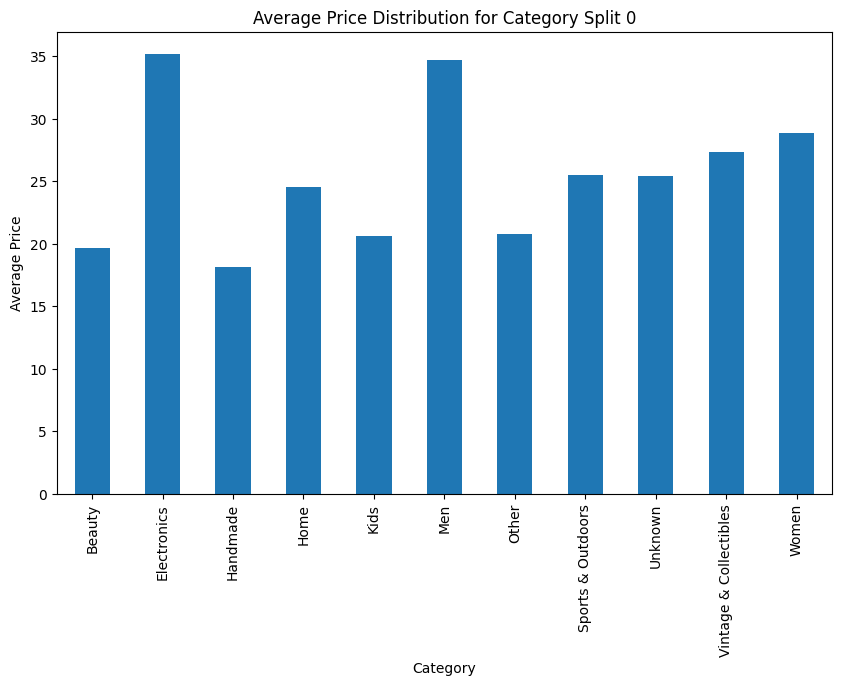

In [18]:
# Now let's calculate the average price for each category in each column

category_avg = merged_data.groupby(0)['price'].mean()

# Plotting
plt.figure(figsize=(10, 6))
category_avg.plot(kind='bar')
plt.title(f'Average Price Distribution for Category Split {0}')
plt.xlabel('Category')
plt.ylabel('Average Price')
plt.show()

In [19]:

# Get unique categories from column '0'
unique_categories = merged_data[0].unique()
print(unique_categories)


['Men' 'Electronics' 'Women' 'Home' 'Sports & Outdoors'
 'Vintage & Collectibles' 'Beauty' 'Other' 'Kids' 'Unknown' 'Handmade']


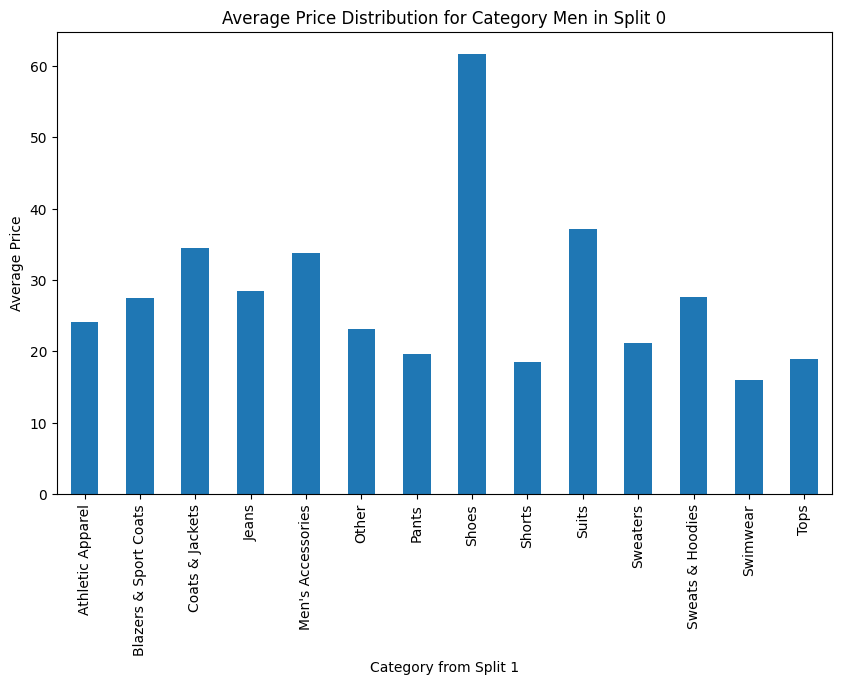

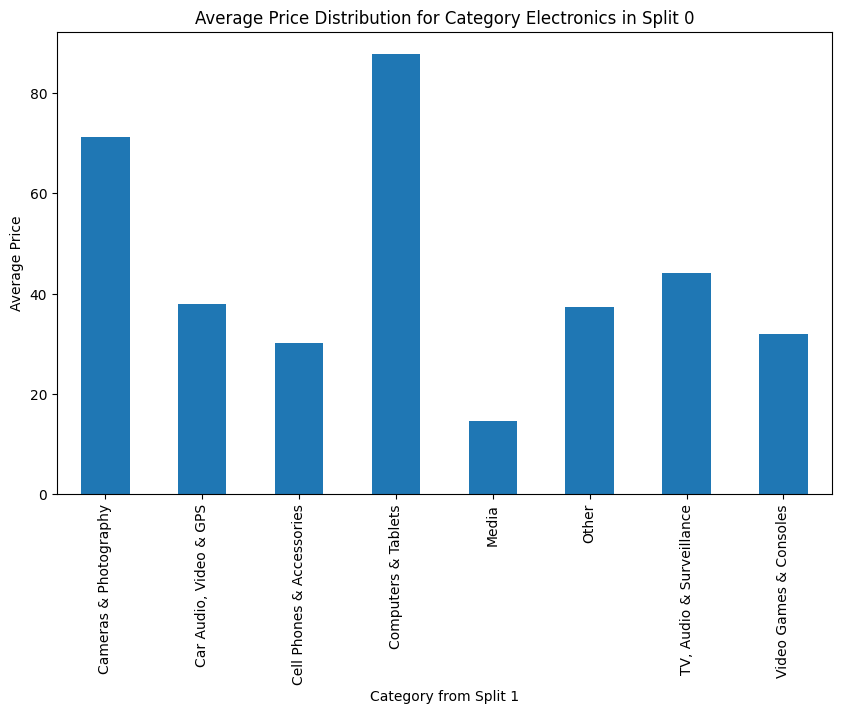

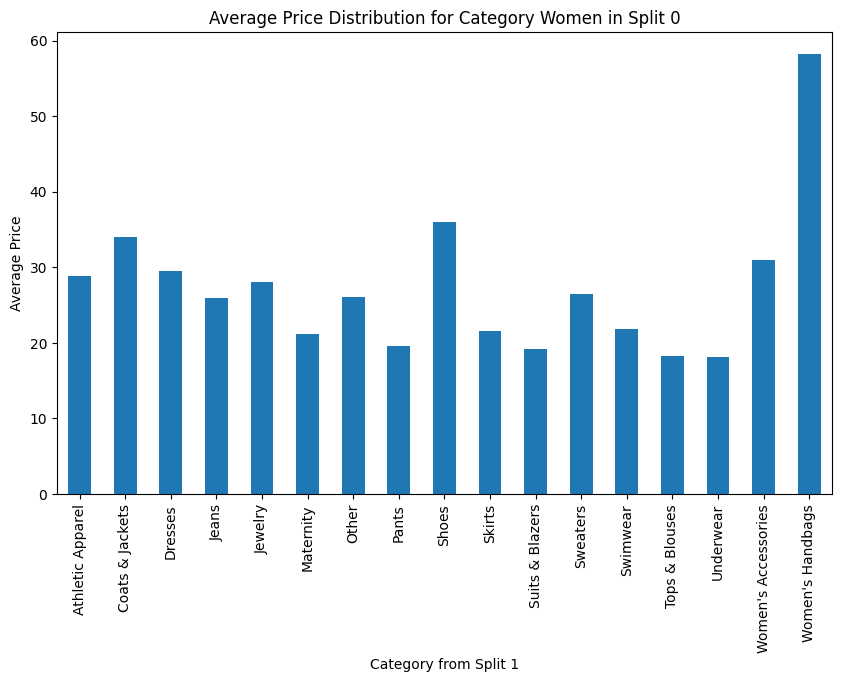

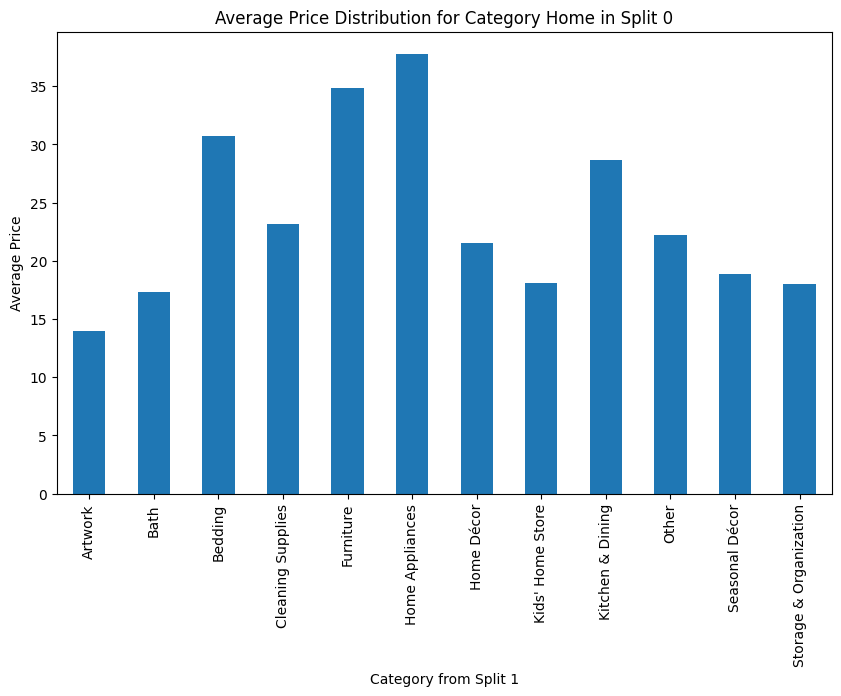

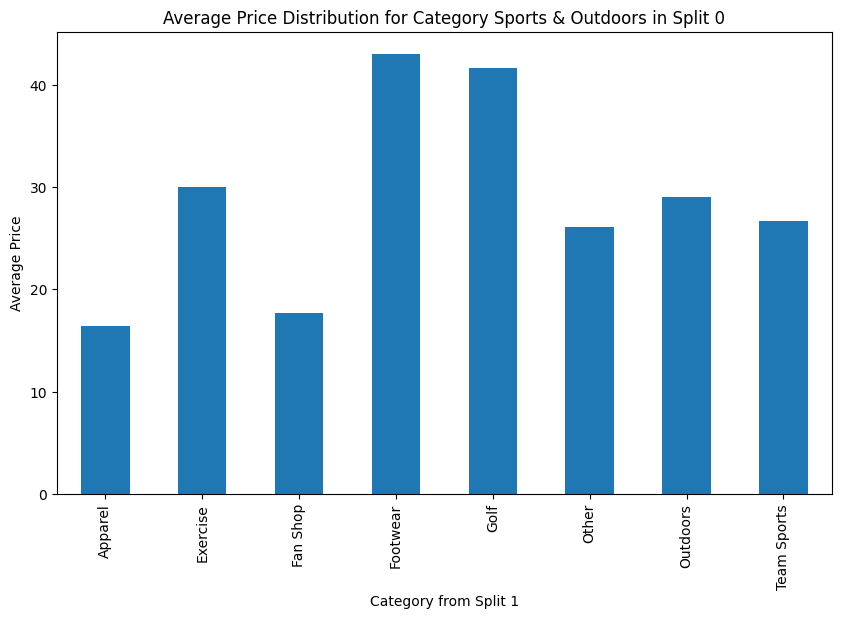

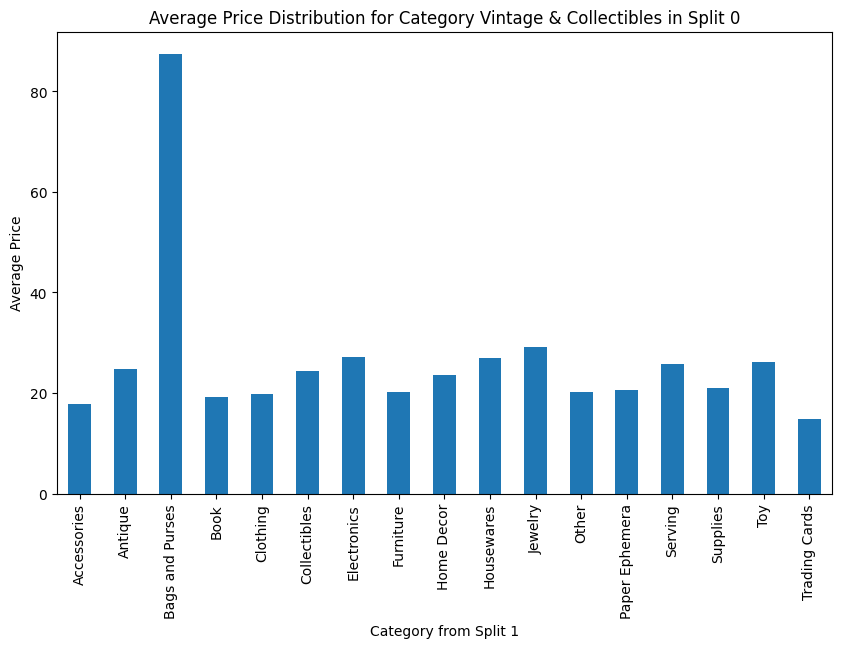

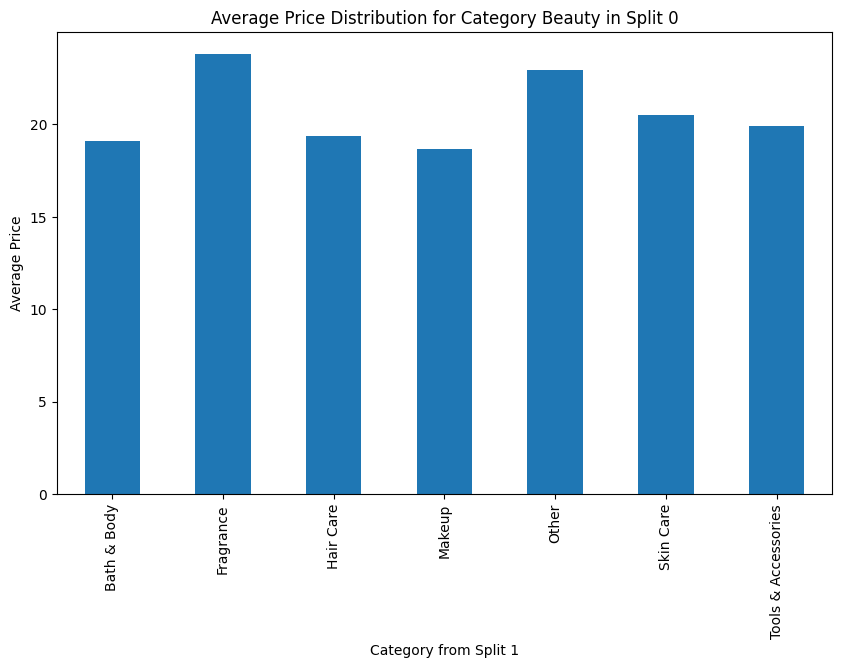

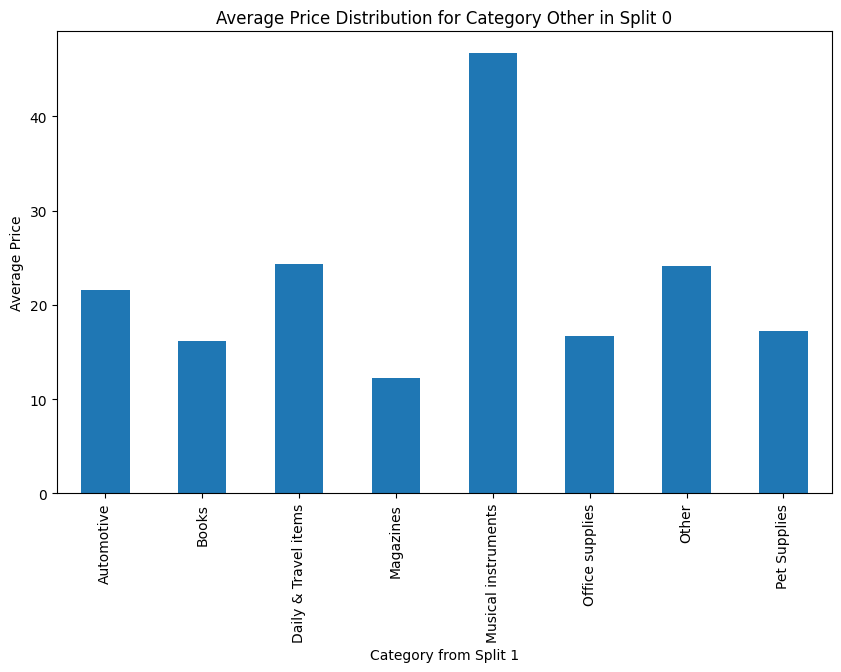

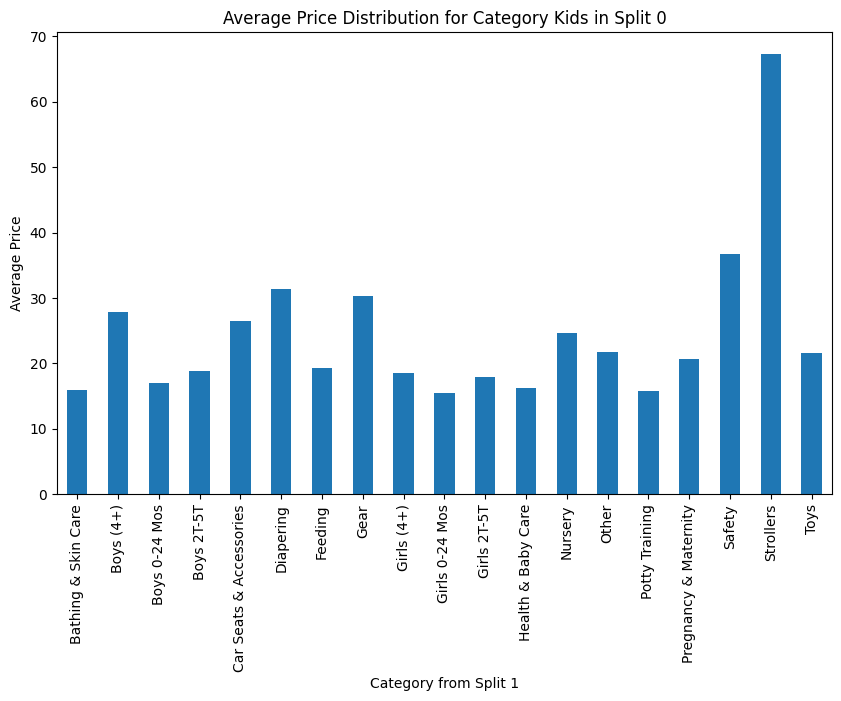

IndexError: index 0 is out of bounds for axis 0 with size 0

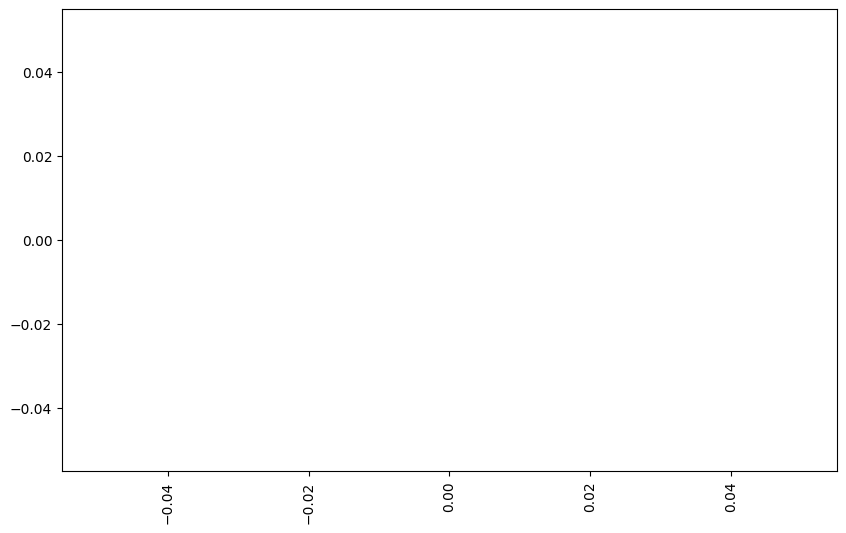

In [20]:

# Plot for each category in column '0'
for category in unique_categories:
    if category!= 'No Data':
        # Filter data for the current category
        filtered_data = merged_data[merged_data[0] == category]
        
        # Calculate the average price for each category in column '1'
        category_avg = filtered_data.groupby(1)['price'].mean()
        
        # Plotting
        plt.figure(figsize=(10, 6))
        category_avg.plot(kind='bar')
        plt.title(f'Average Price Distribution for Category {category} in Split 0')
        plt.xlabel('Category from Split 1')
        plt.ylabel('Average Price')
        plt.show()

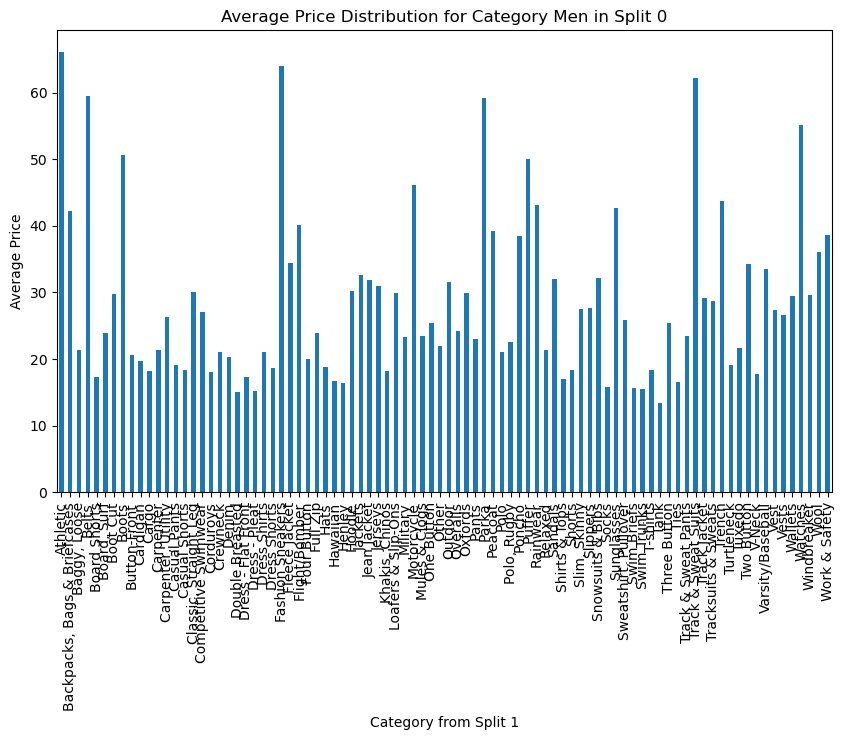

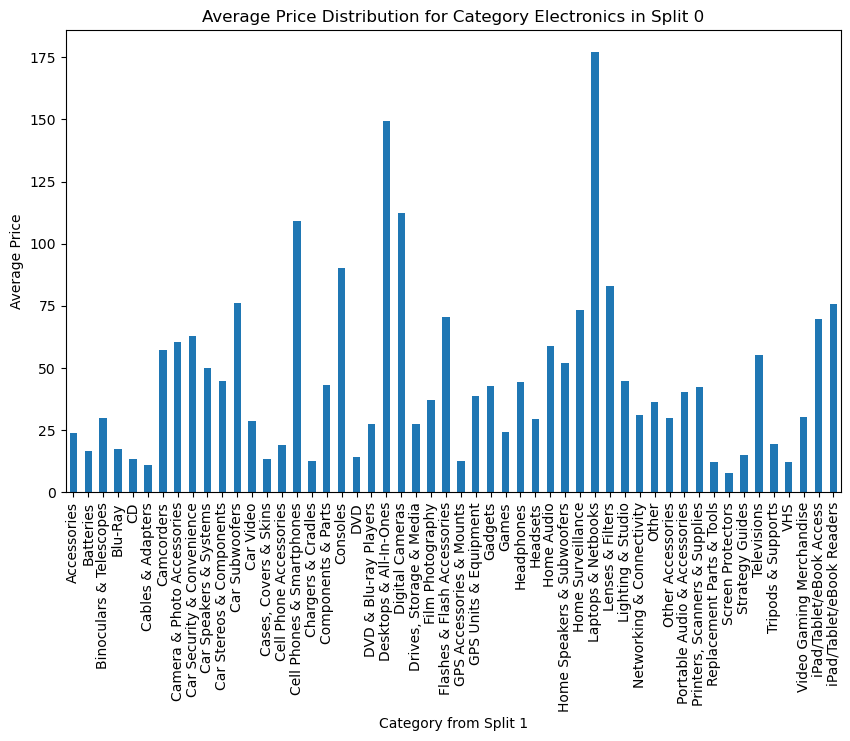

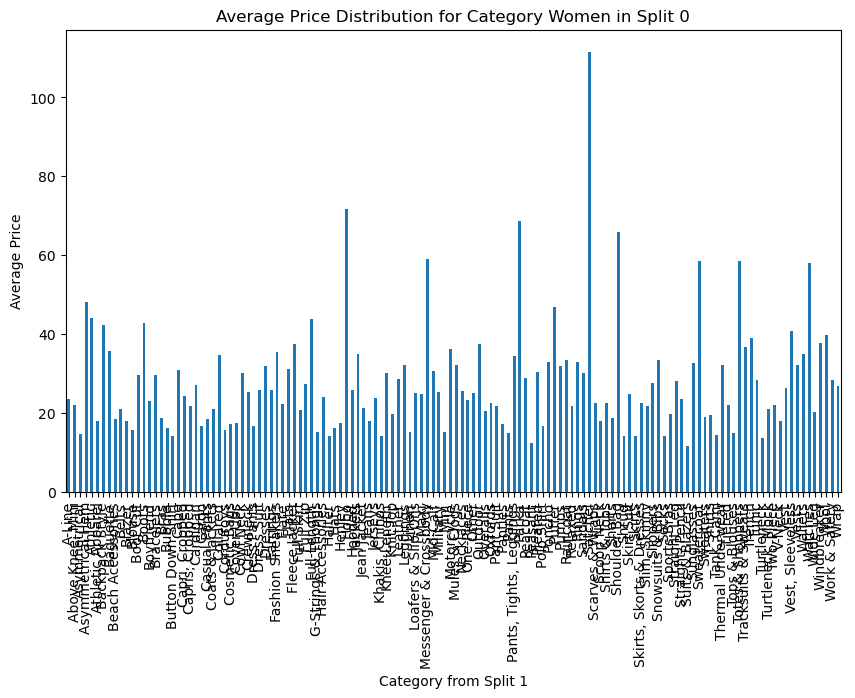

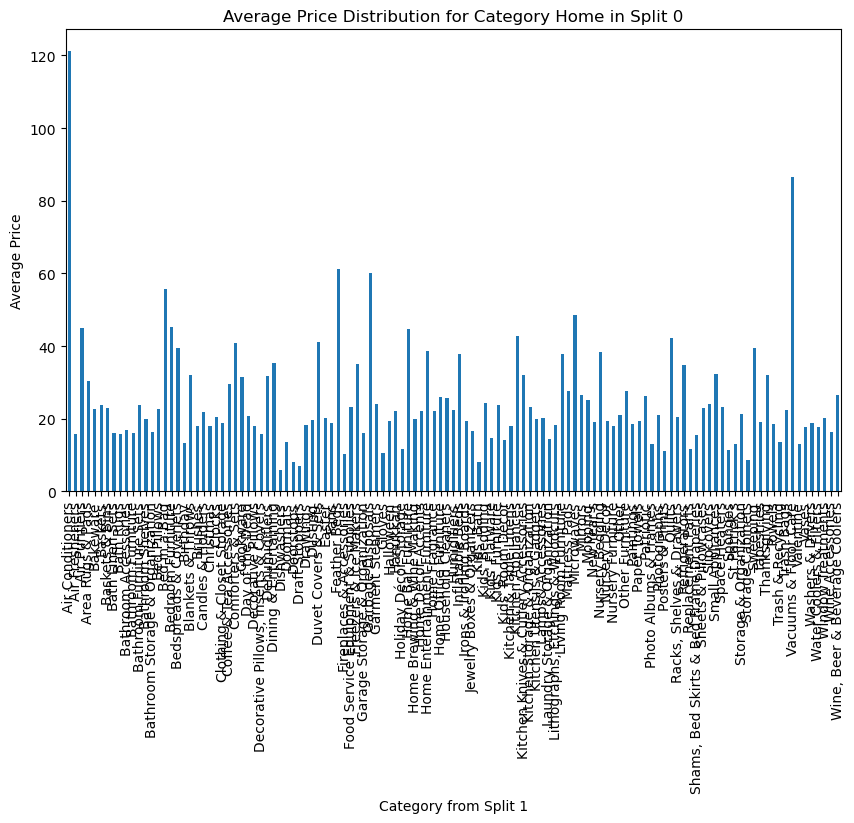

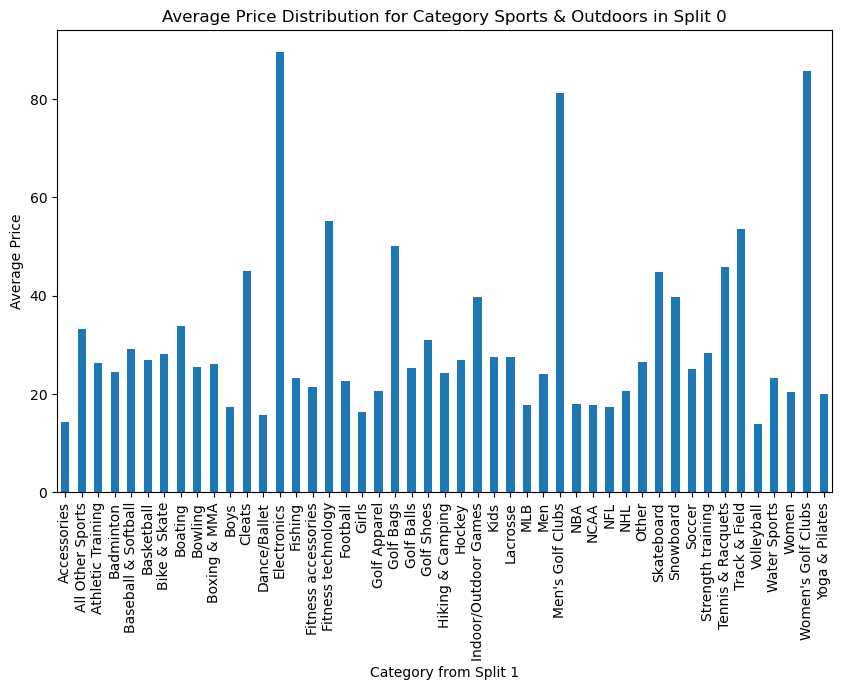

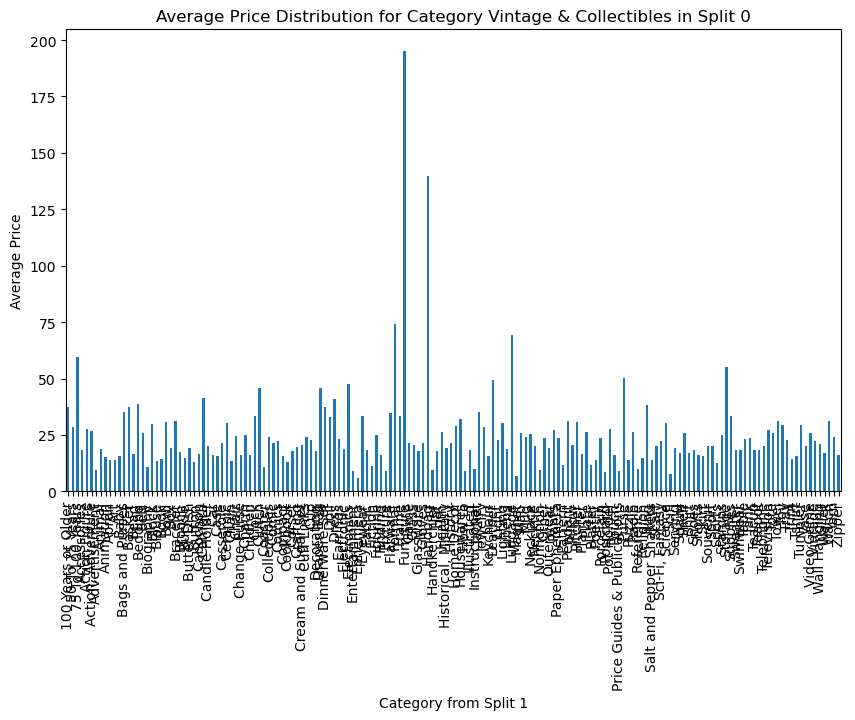

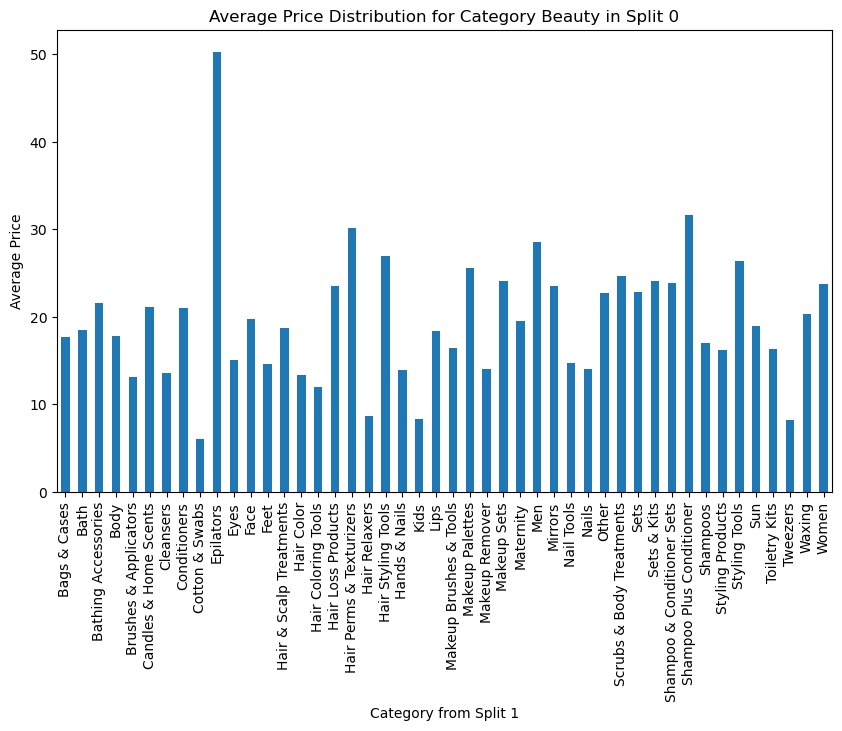

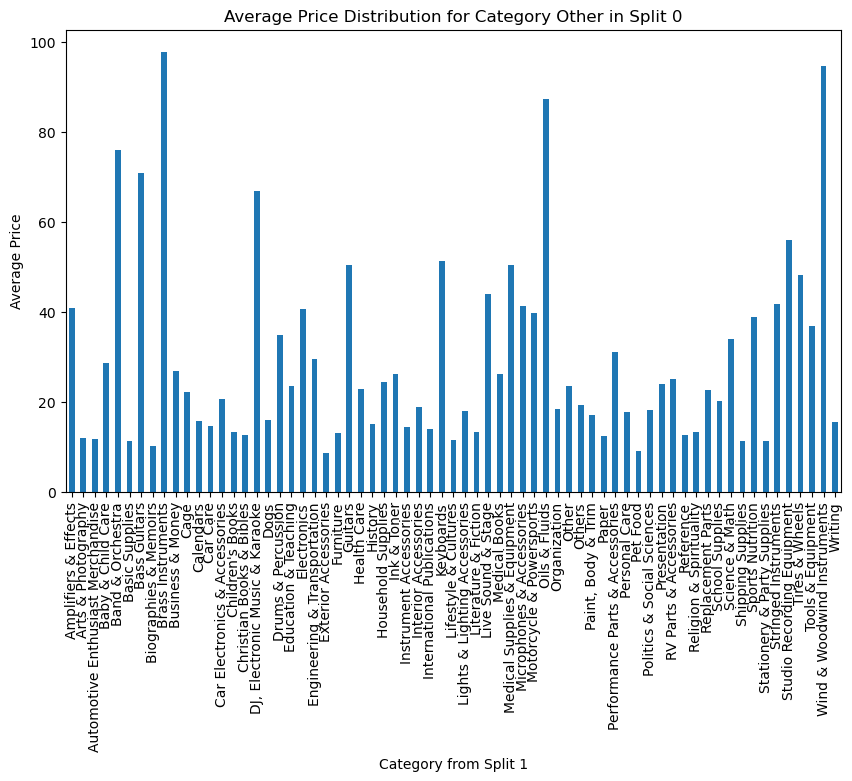

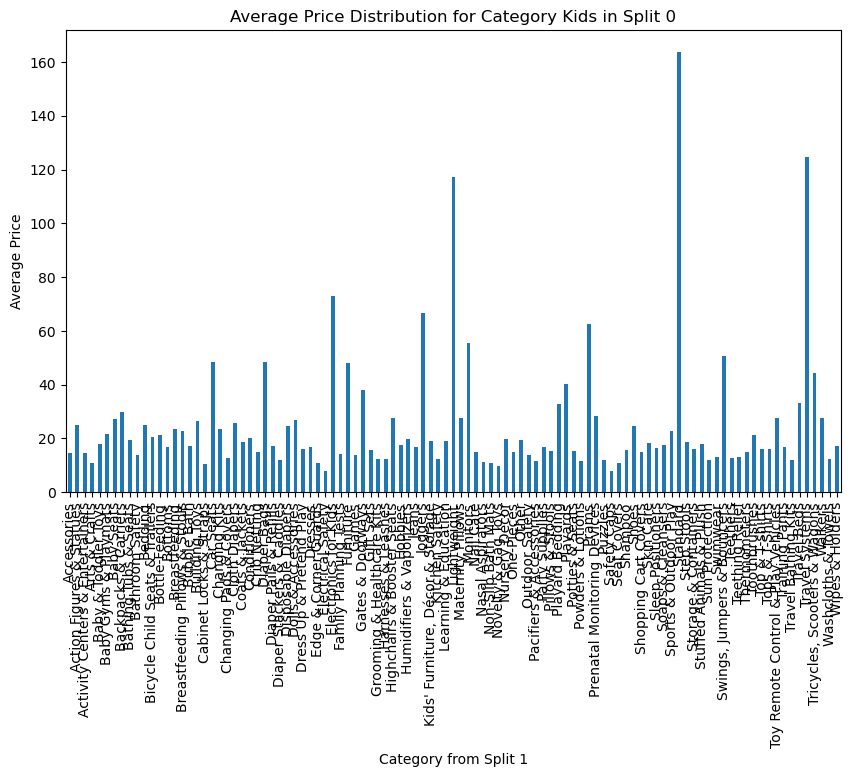

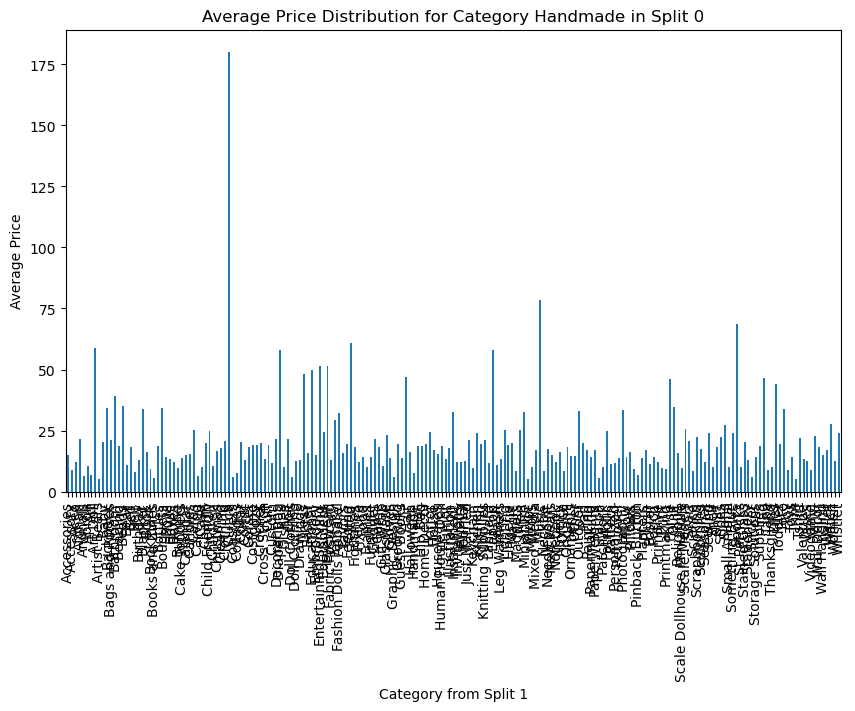

In [ ]:

# Plot for each category in column '0'
for category in unique_categories:
    if category!= 'No Data':
        # Filter data for the current category
        filtered_data = merged_data[merged_data[0] == category]
        
        # Calculate the average price for each category in column '1'
        category_avg = filtered_data.groupby(2)['price'].mean()
        
        # Plotting
        plt.figure(figsize=(10, 6))
        category_avg.plot(kind='bar')
        plt.title(f'Average Price Distribution for Category {category} in Split 0')
        plt.xlabel('Category from Split 1')
        plt.ylabel('Average Price')
        plt.show()

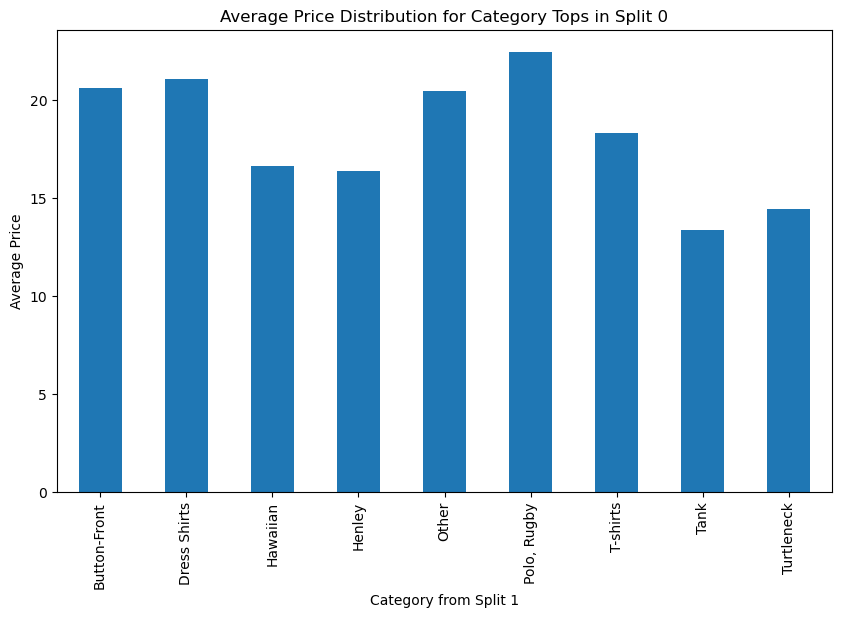

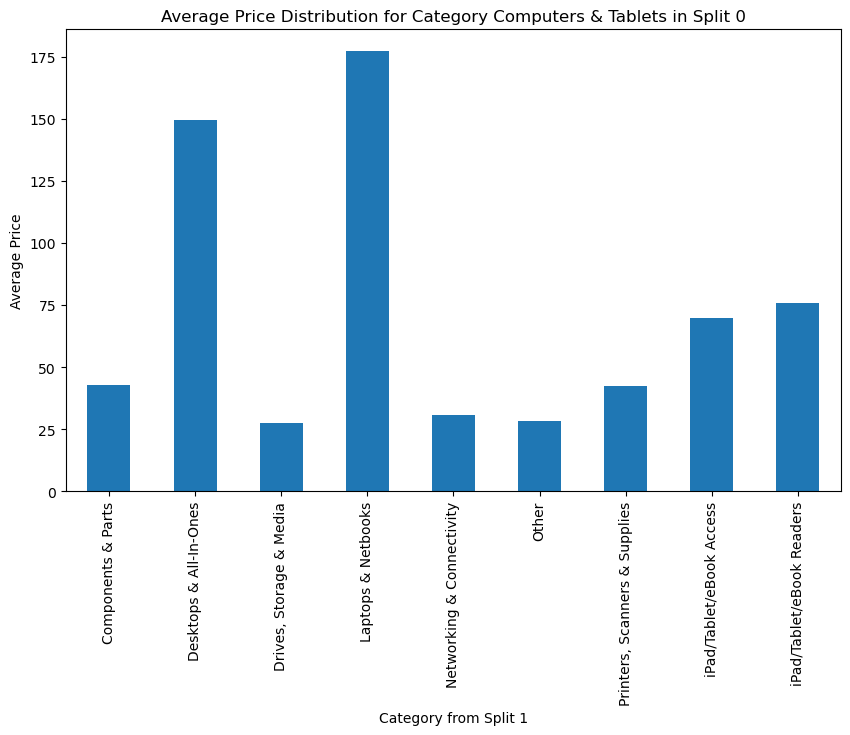

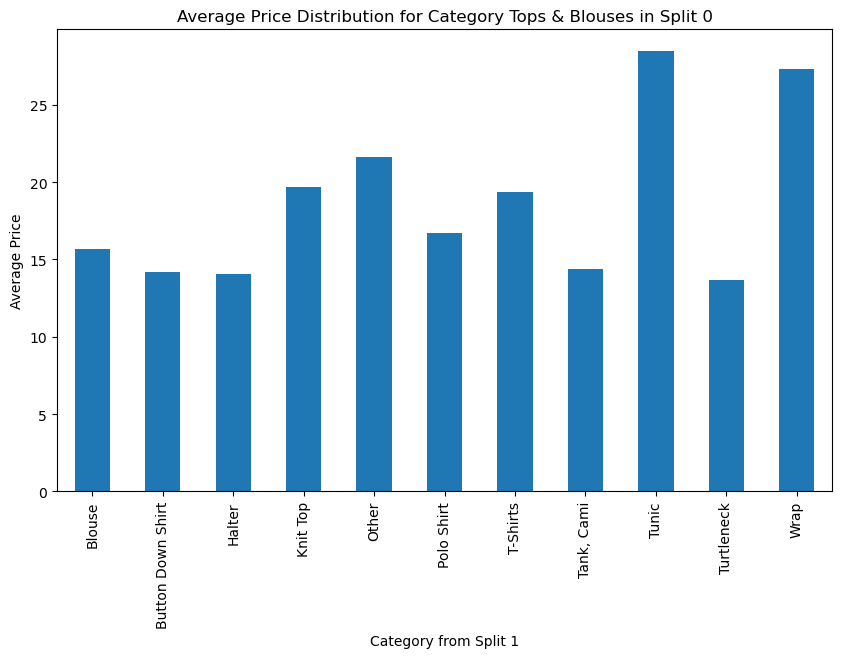

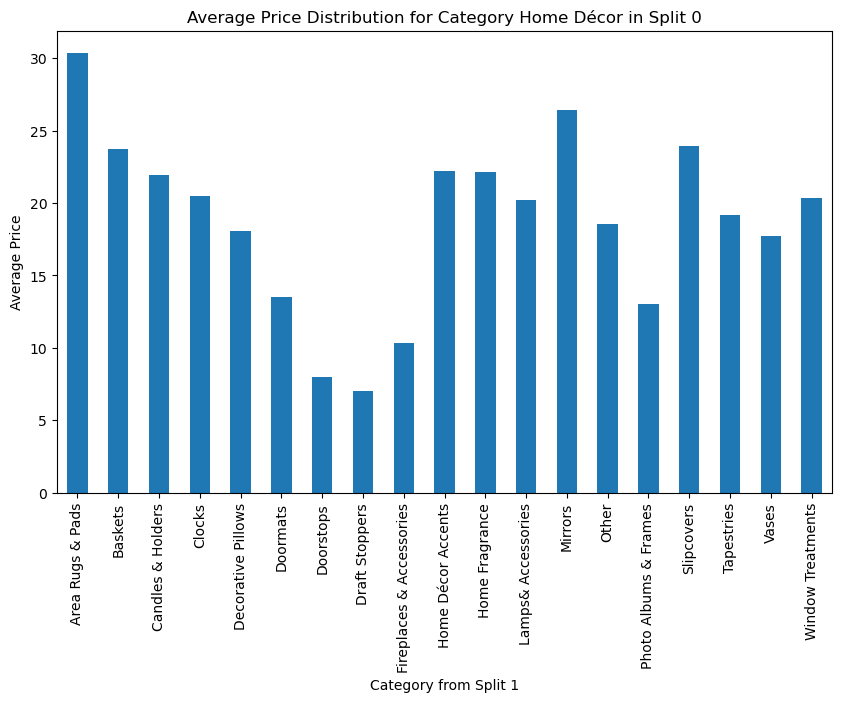

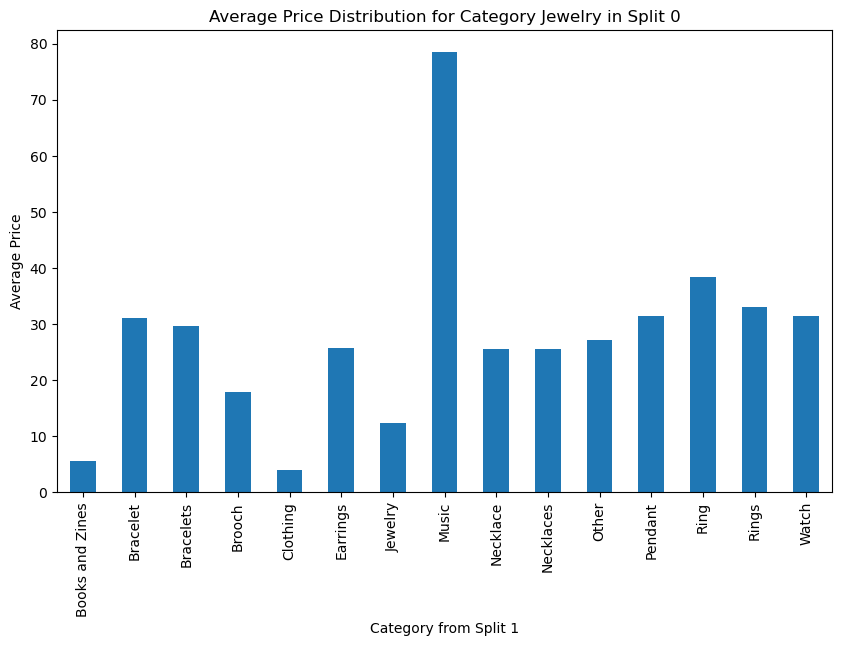

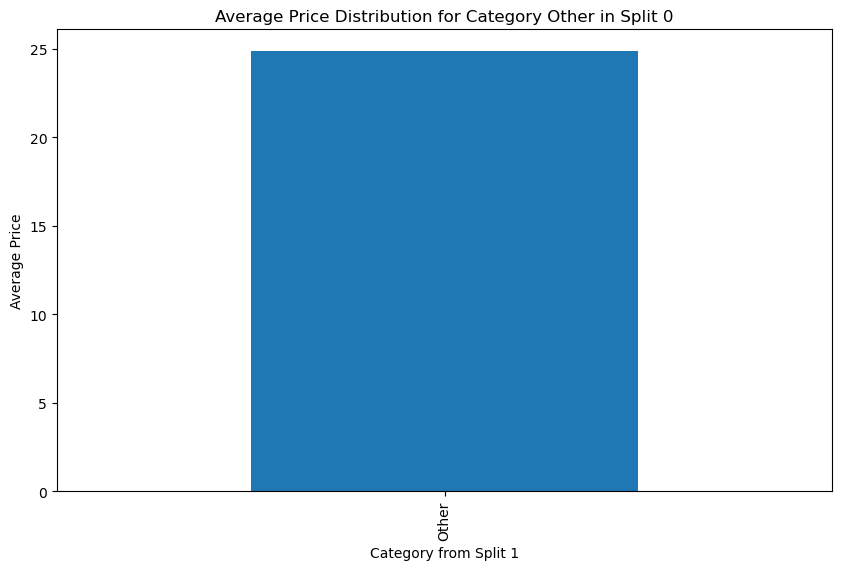

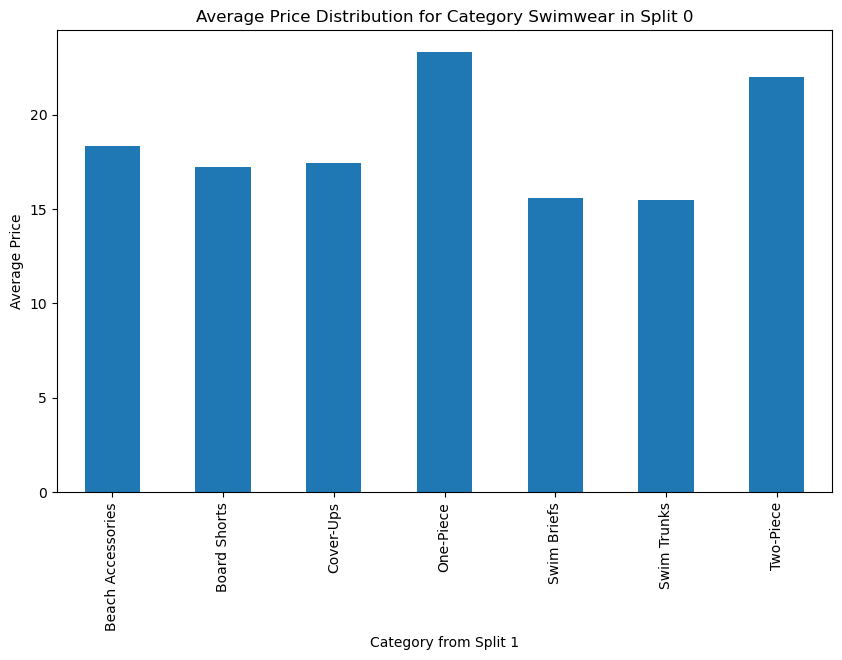

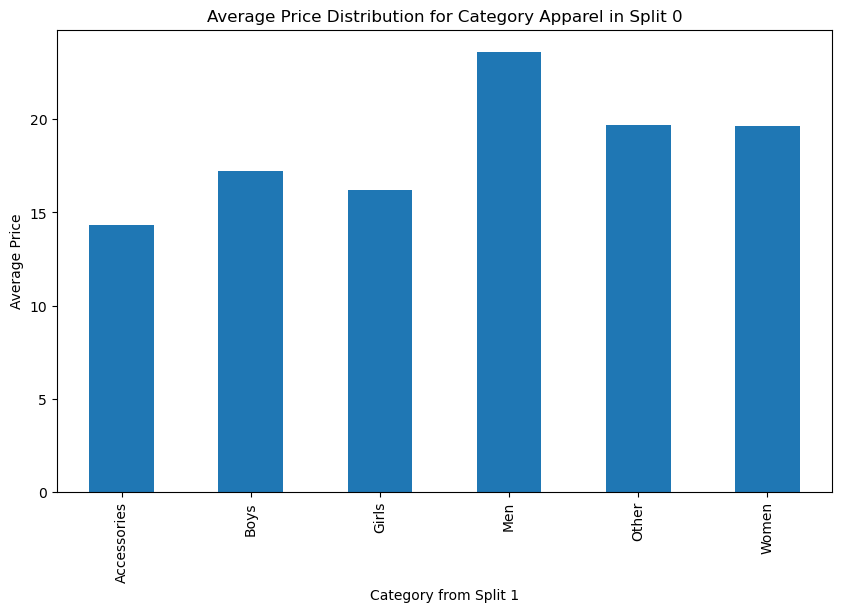

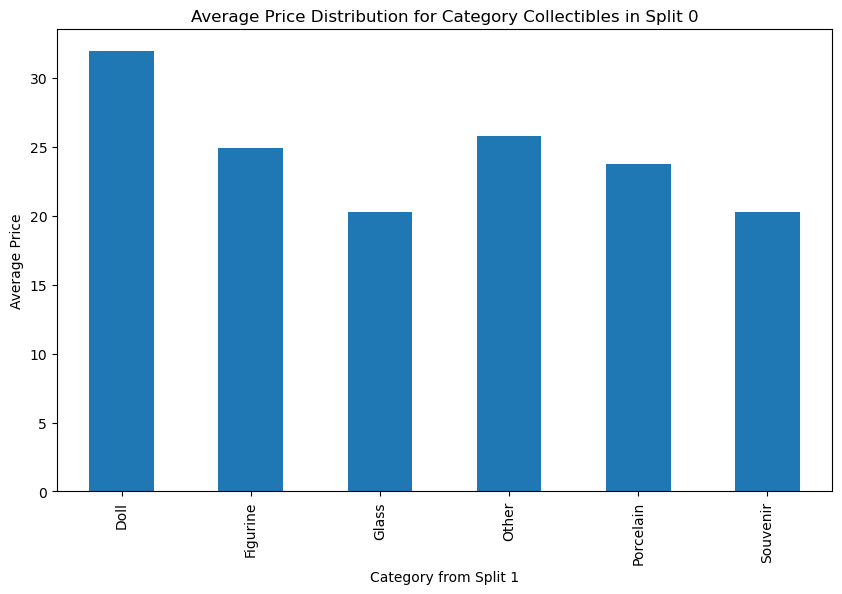

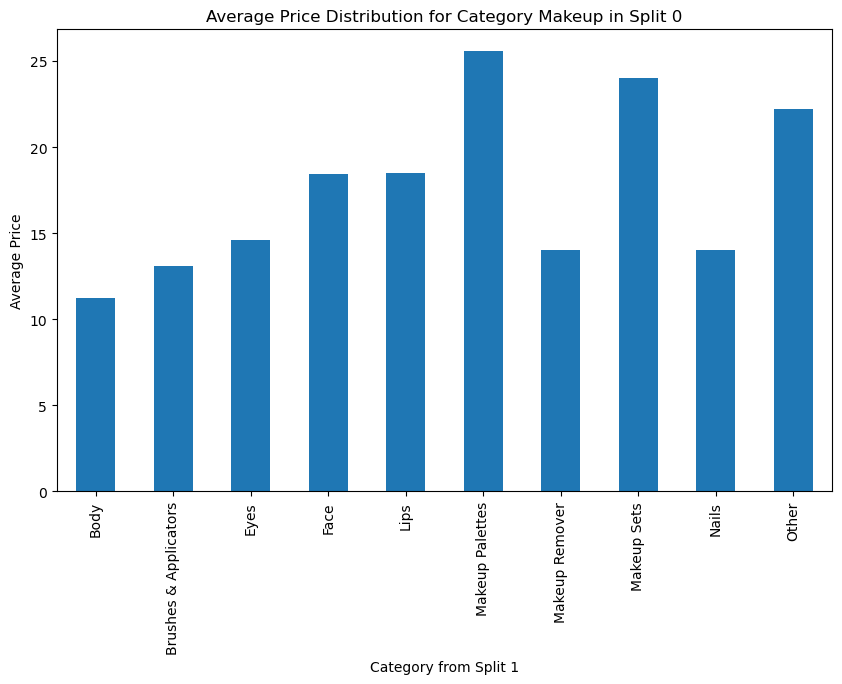

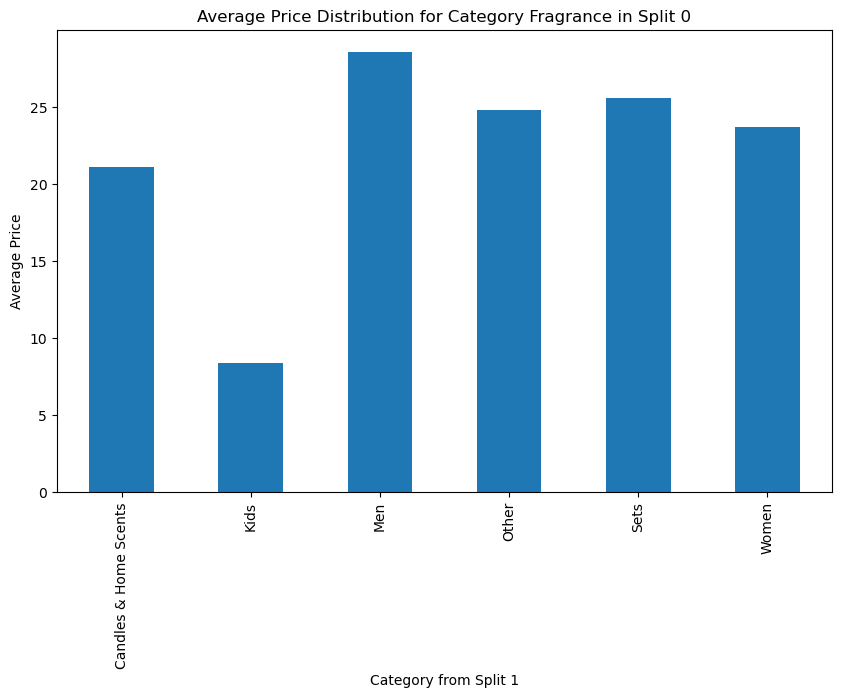

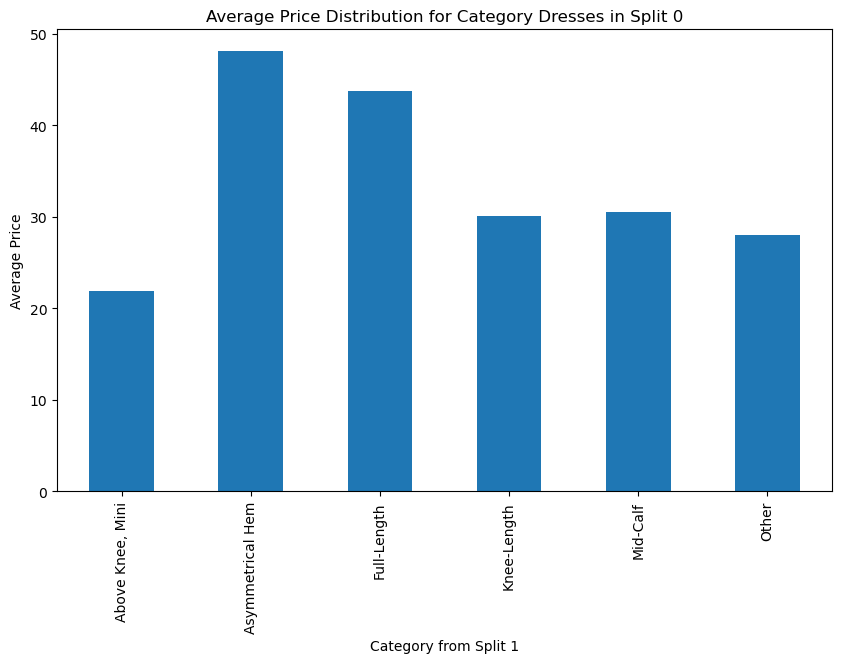

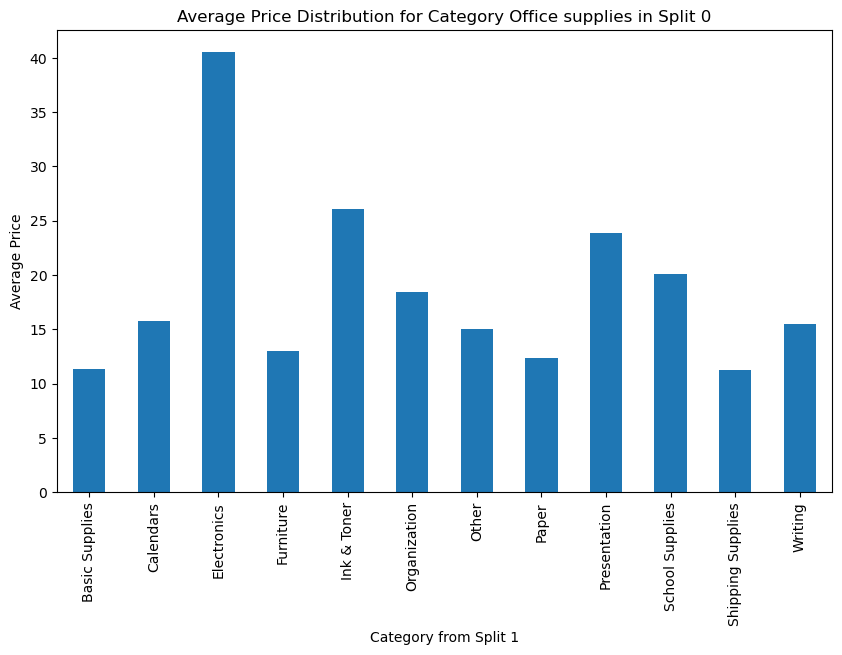

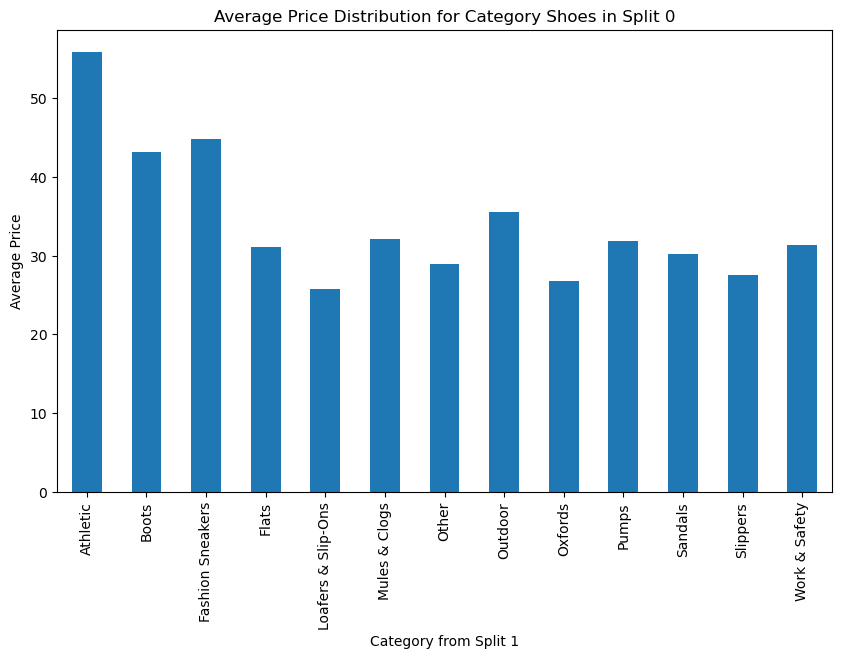

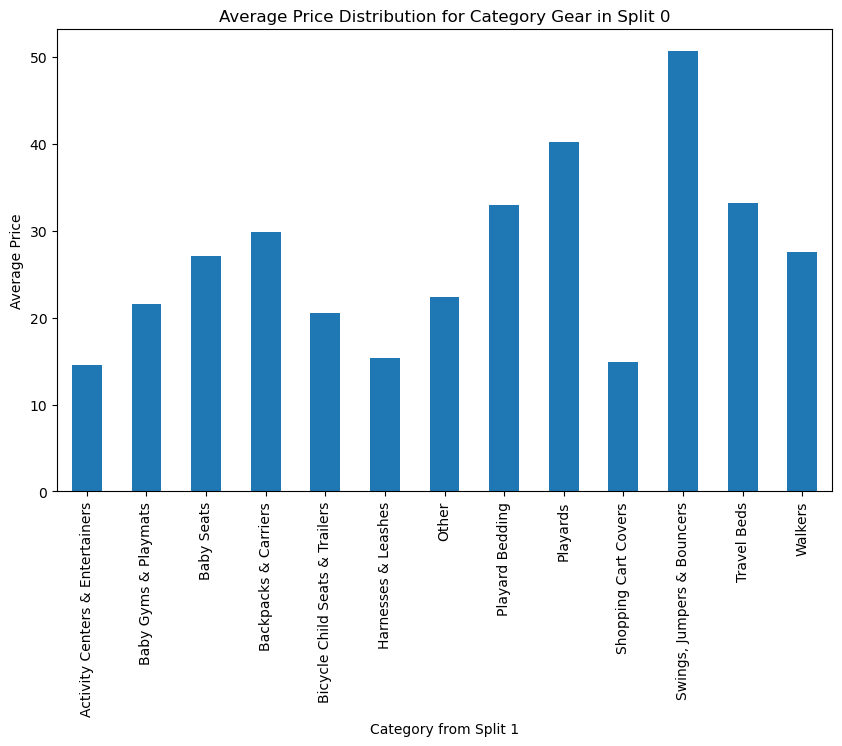

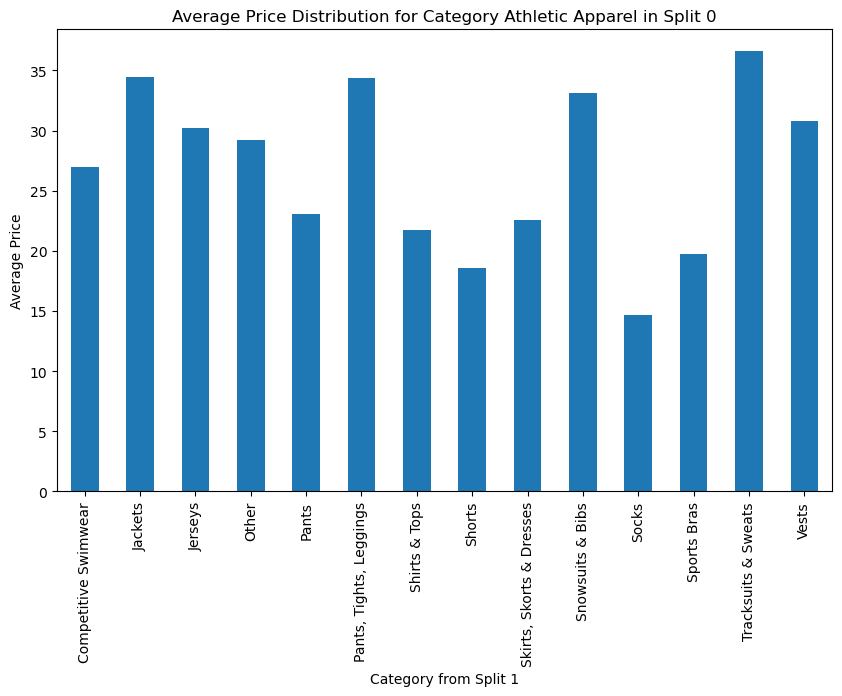

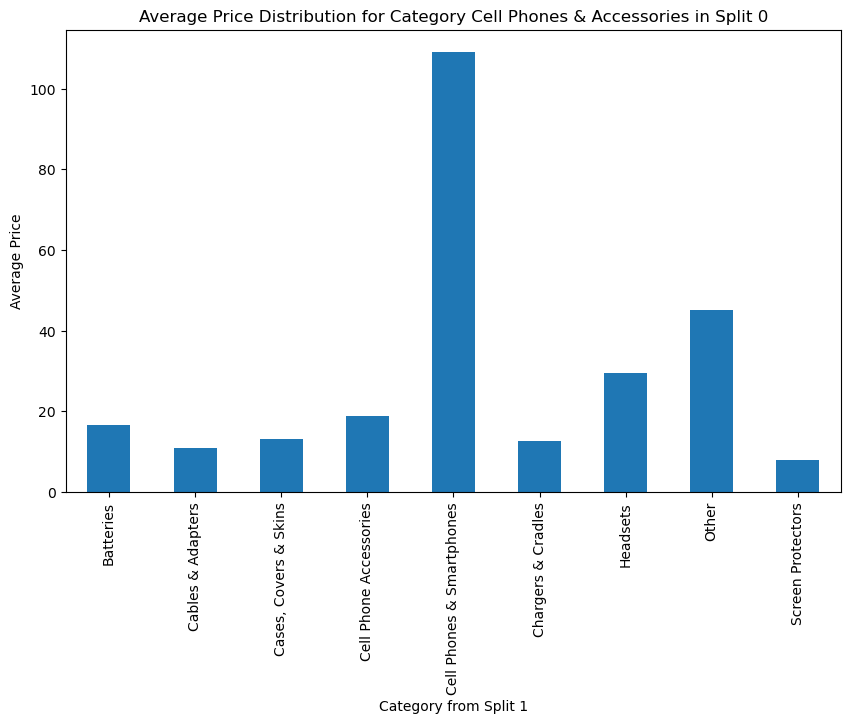

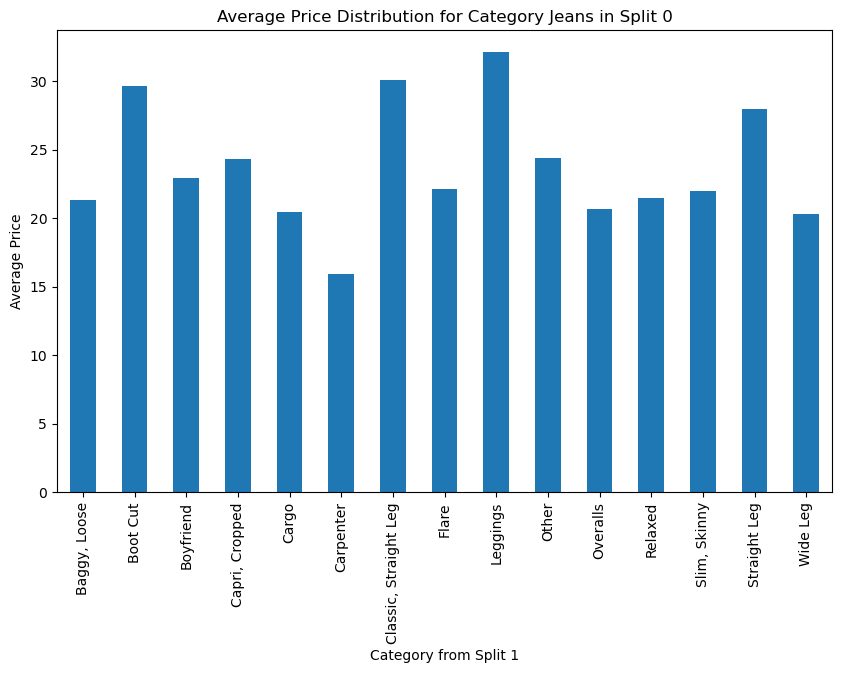

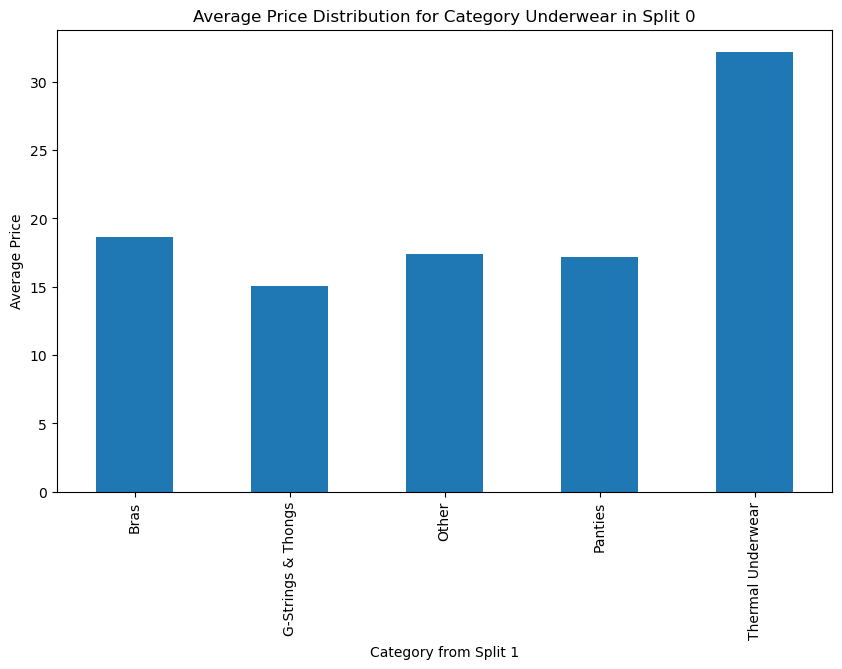

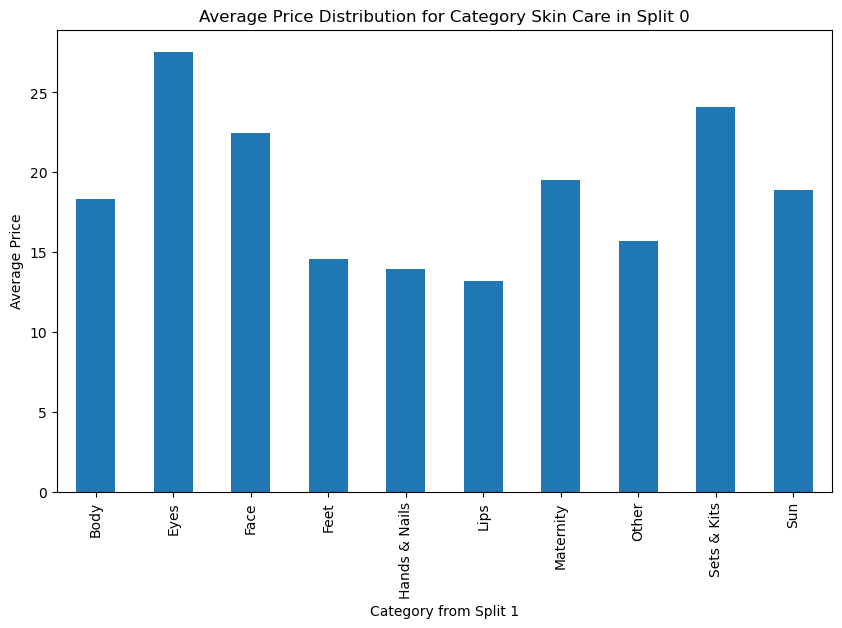

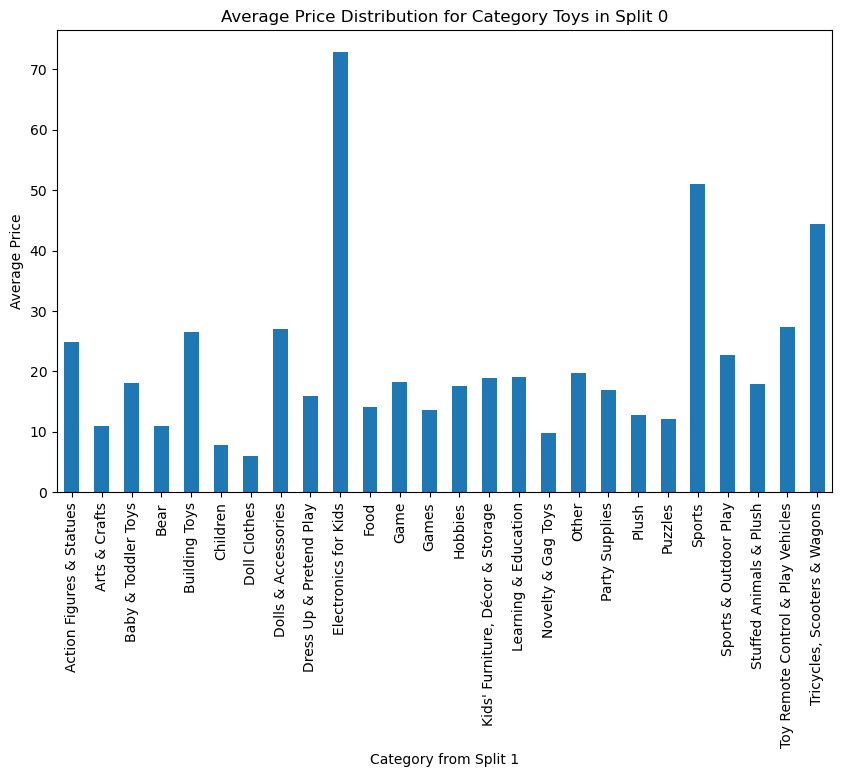

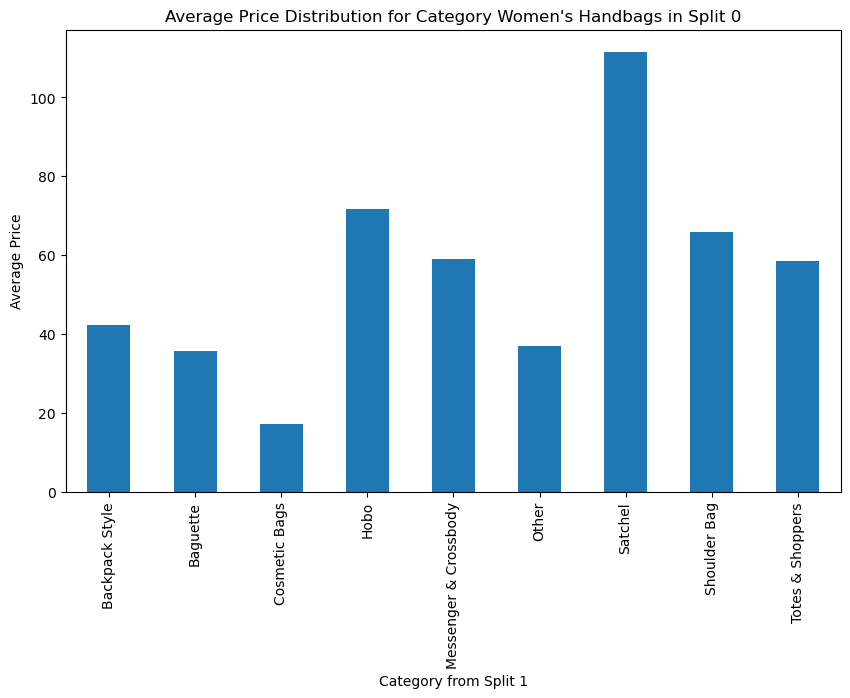

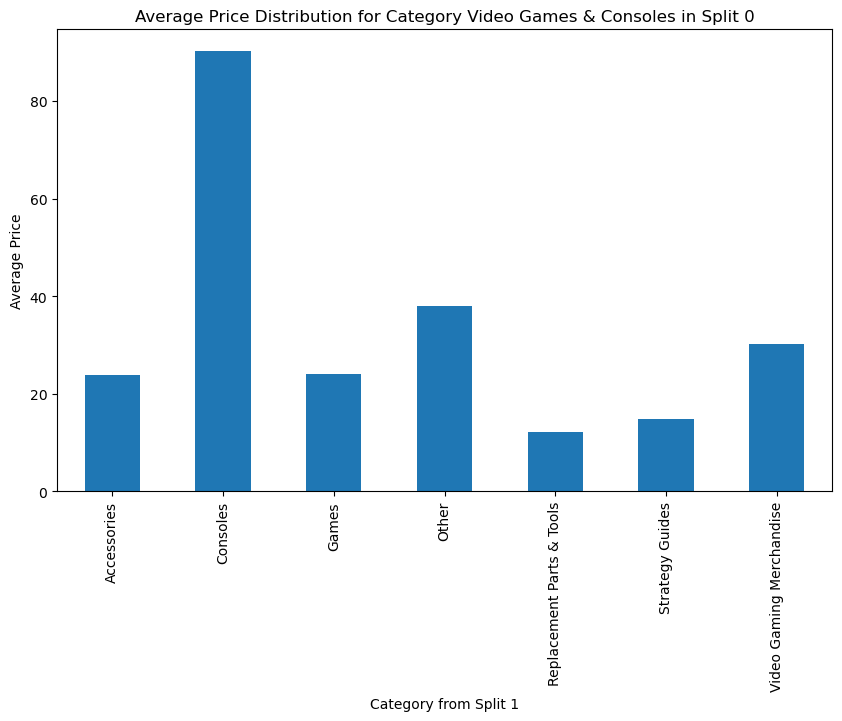

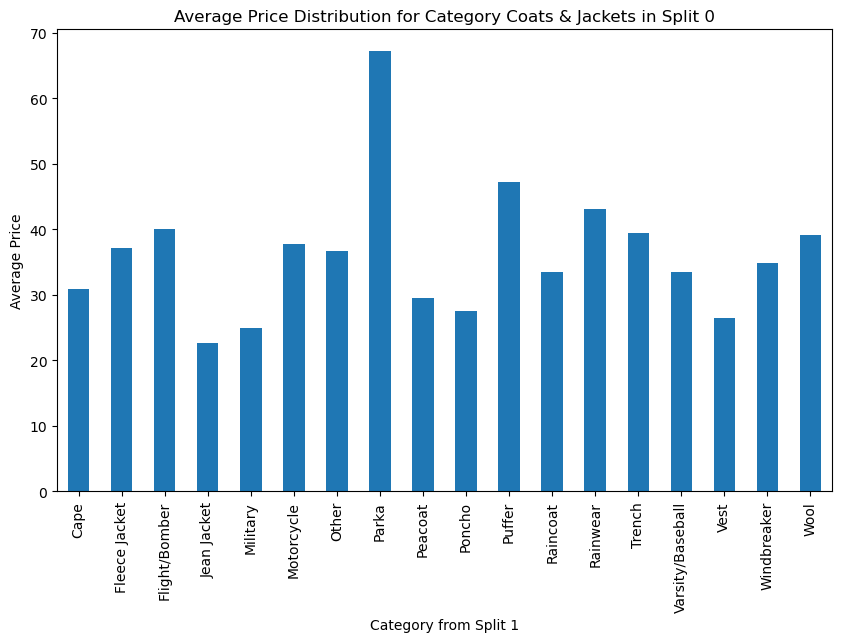

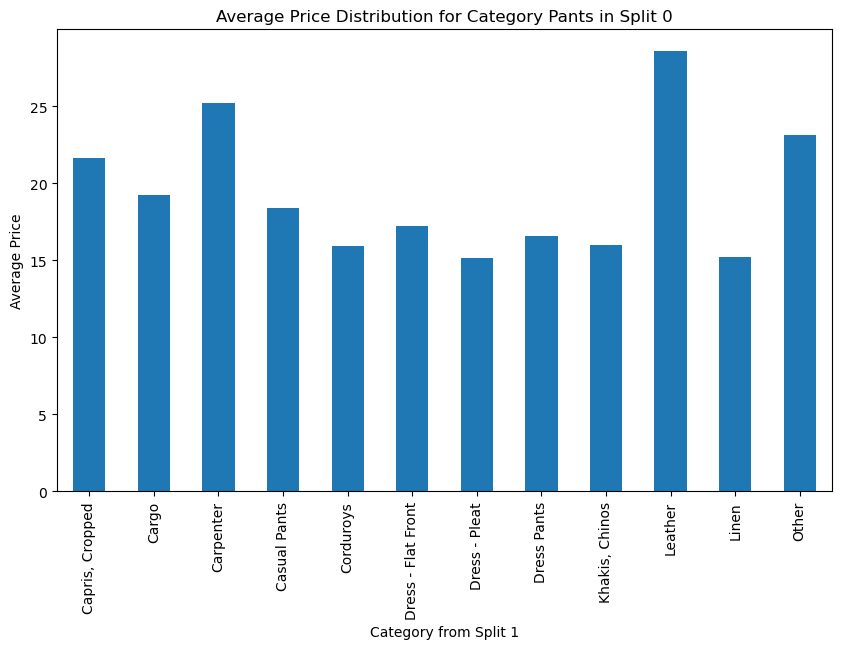

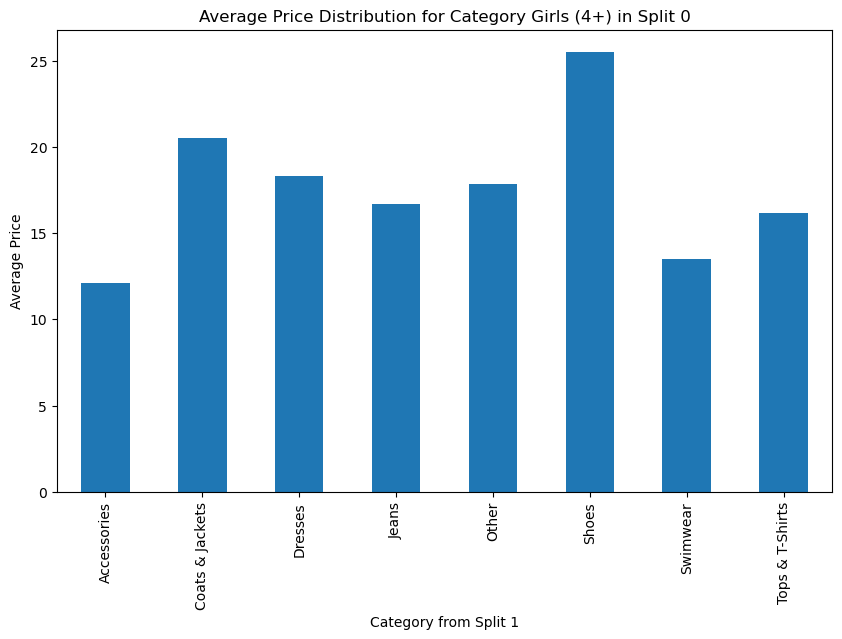

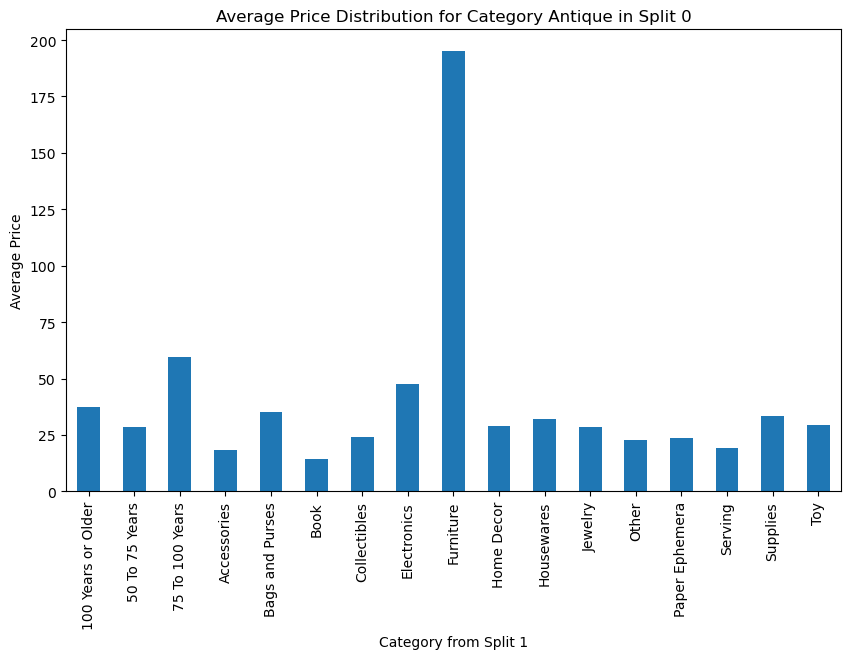

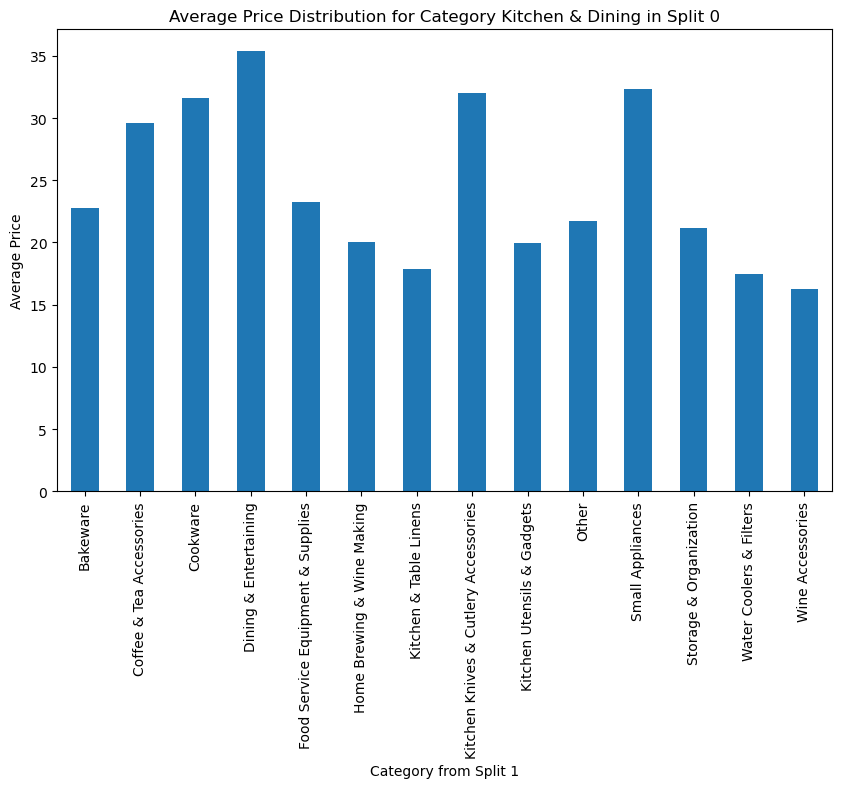

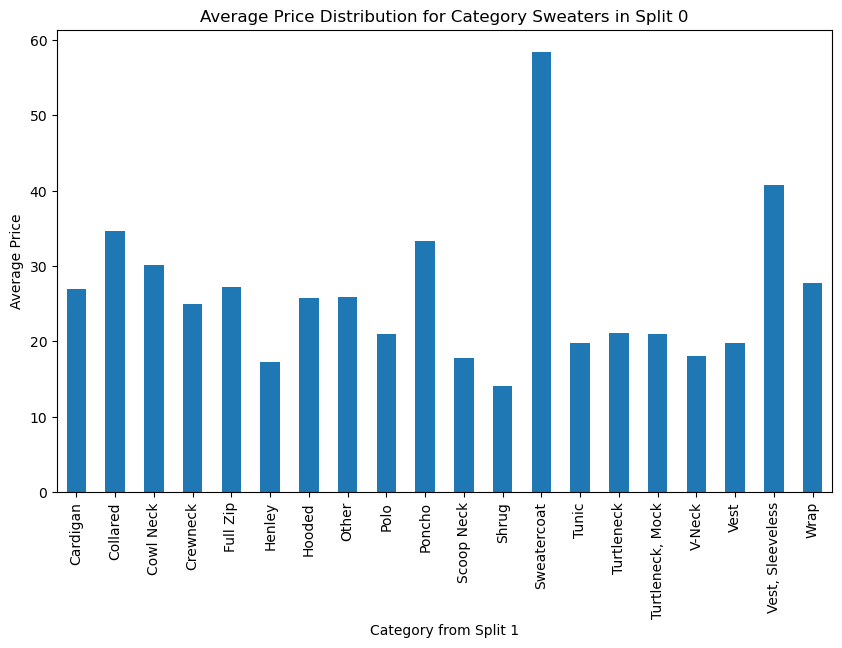

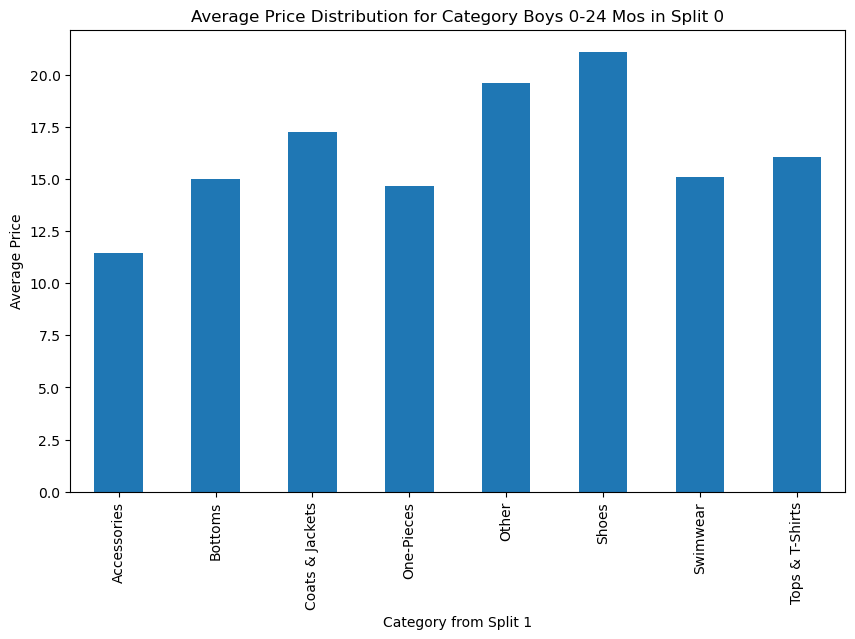

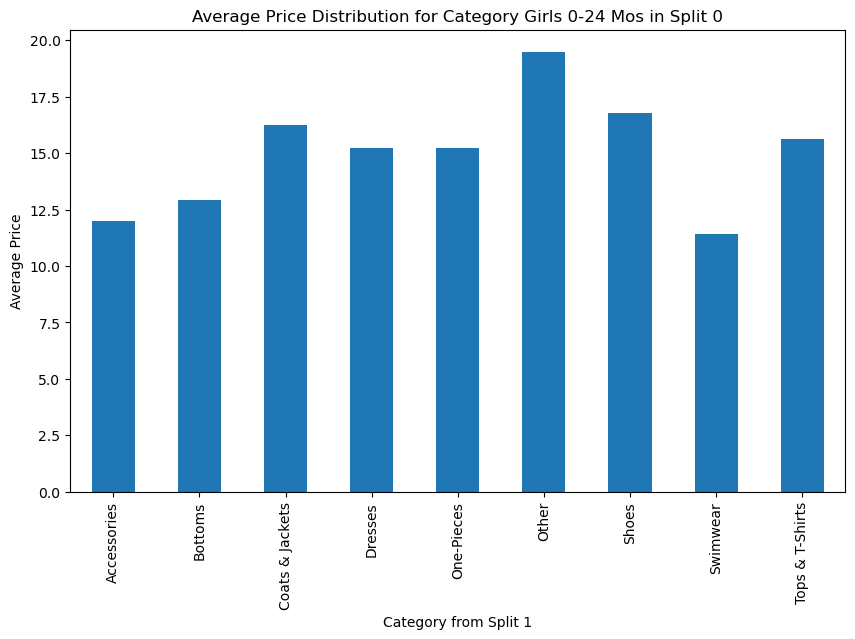

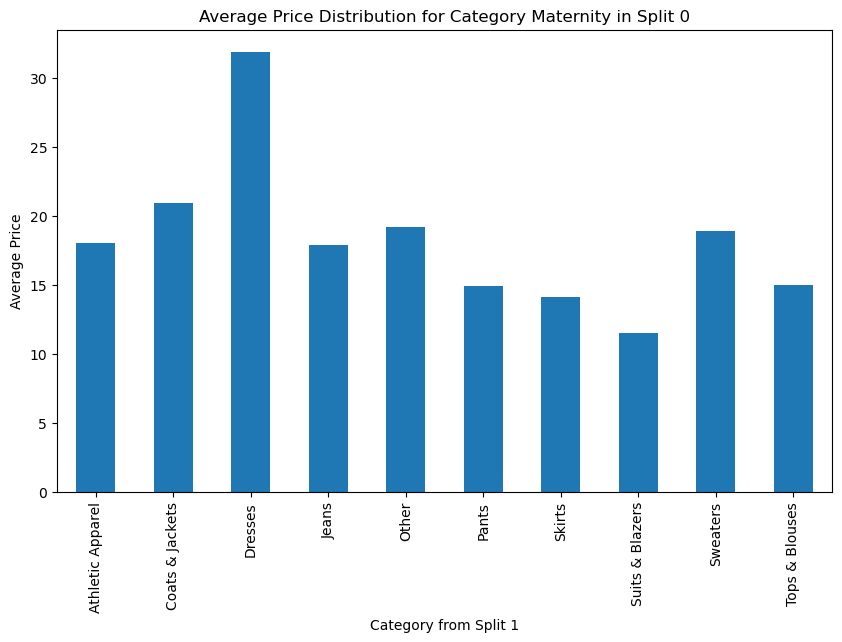

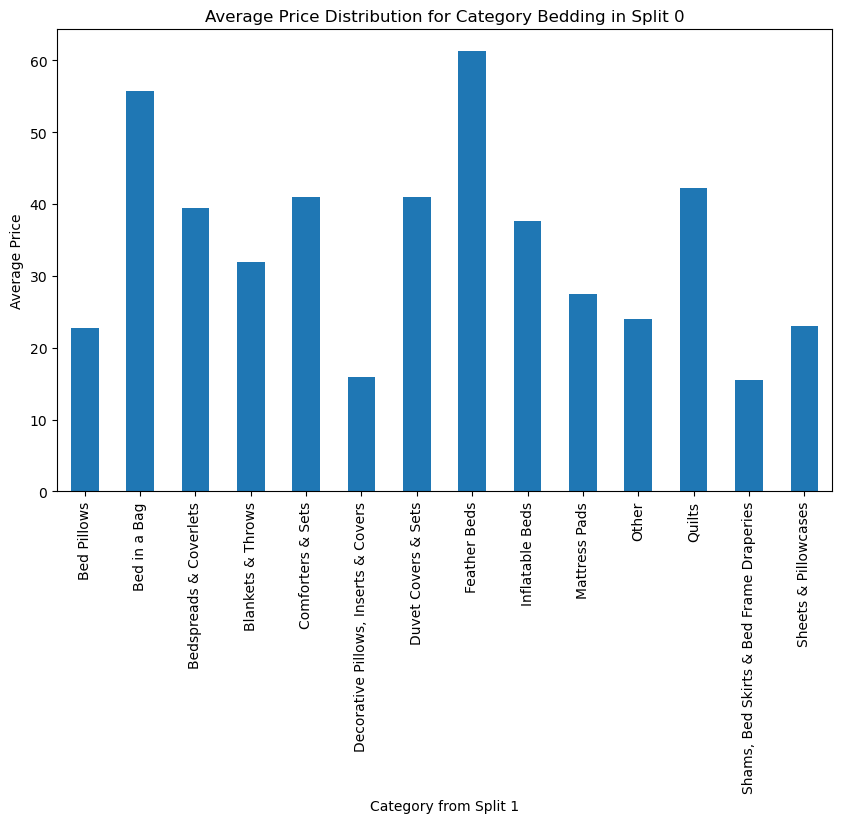

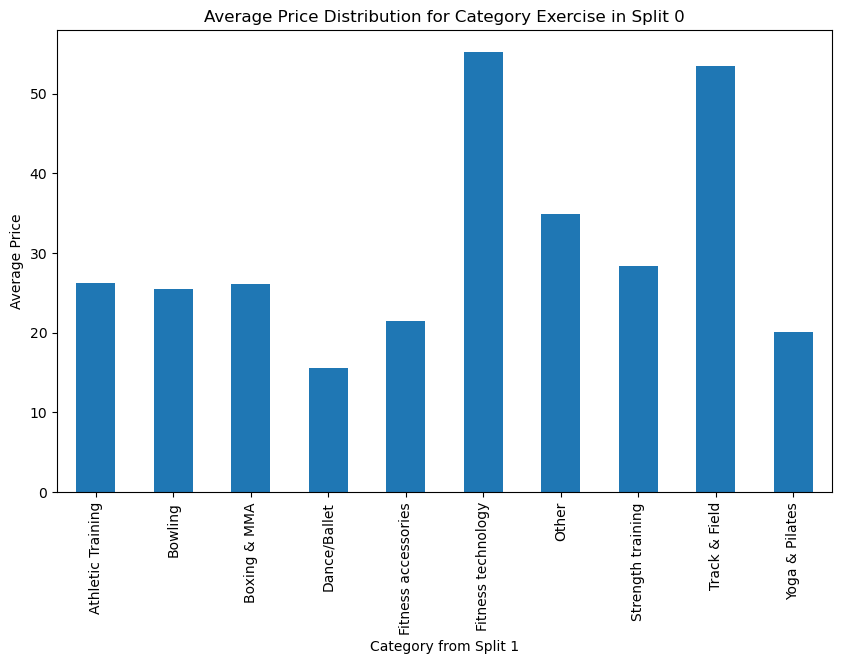

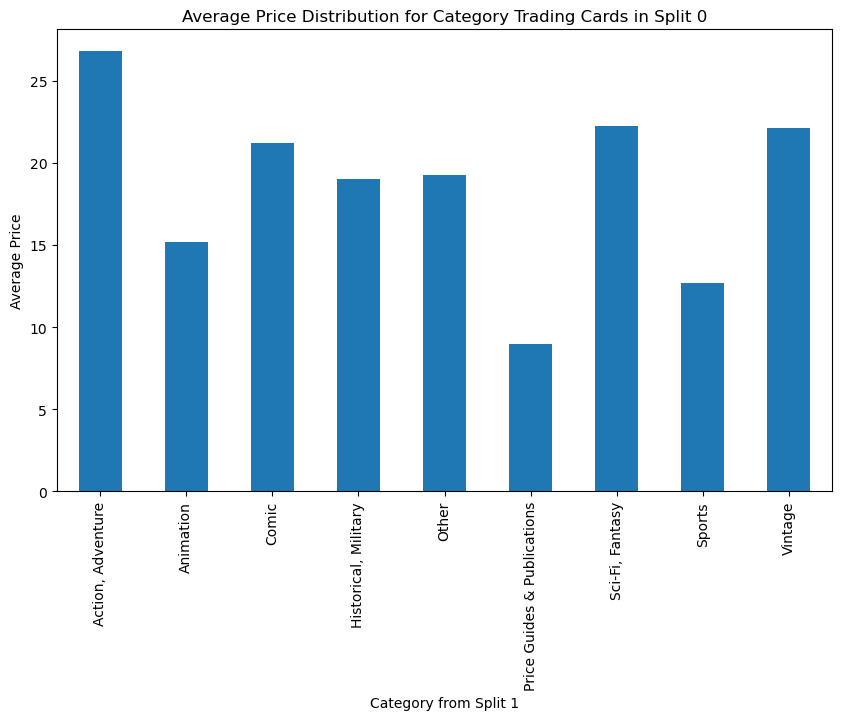

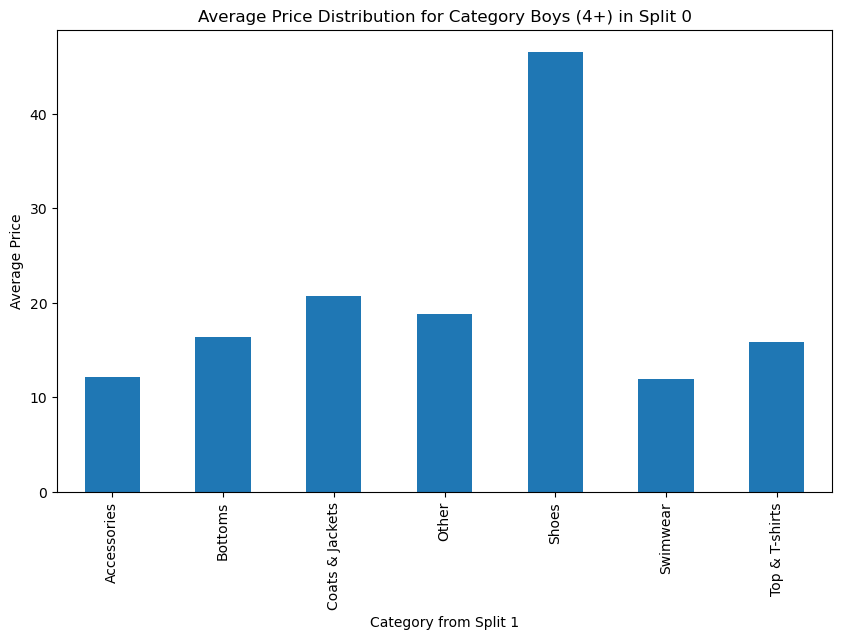

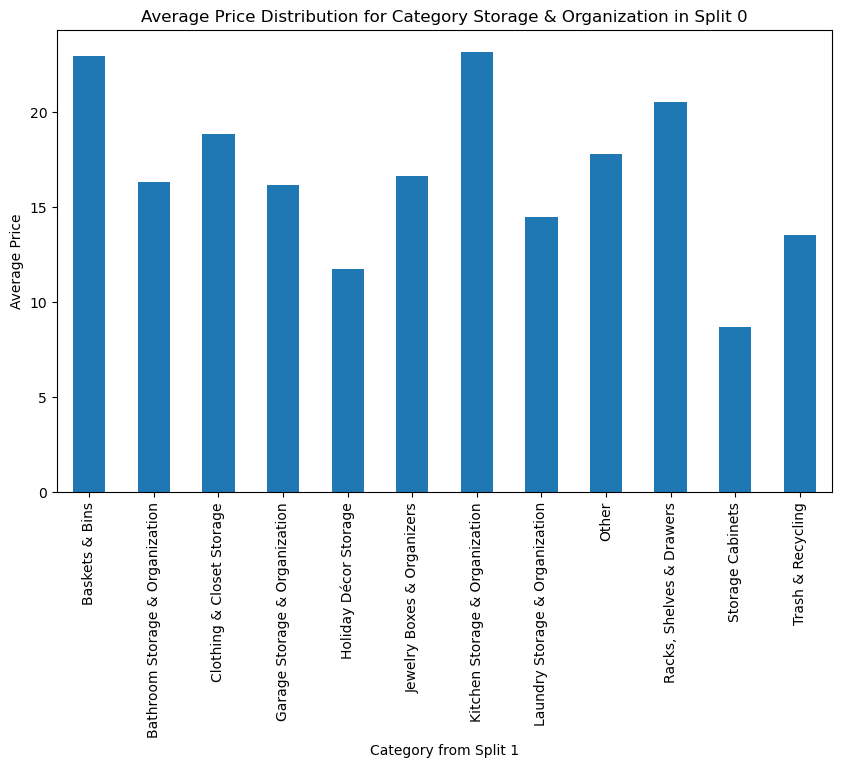

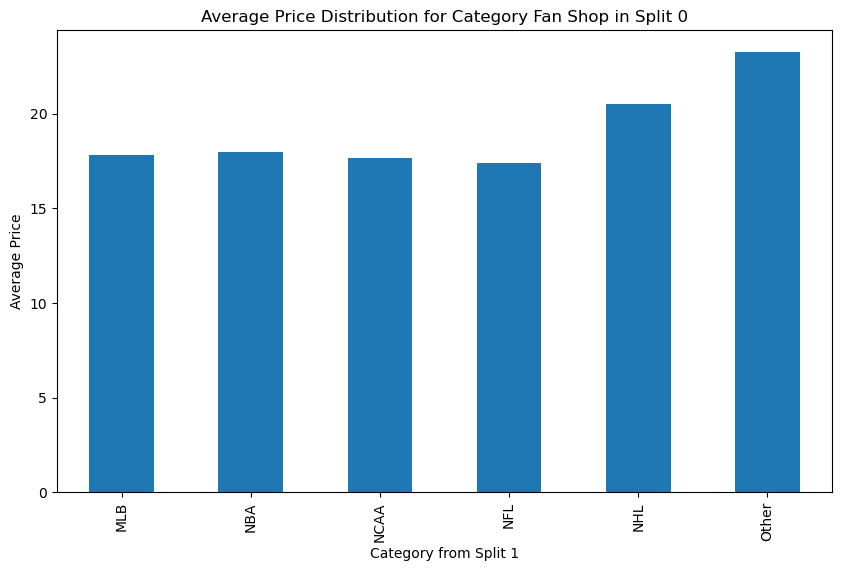

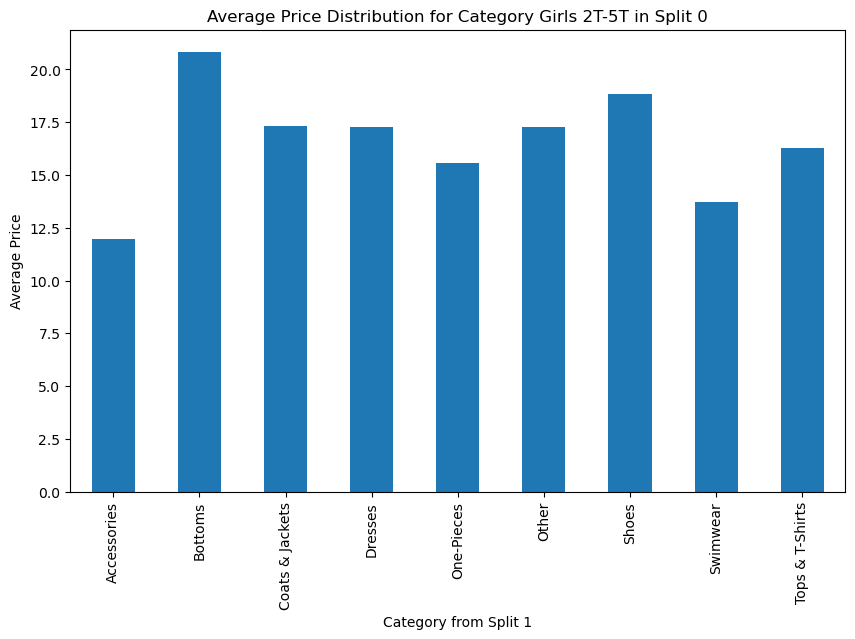

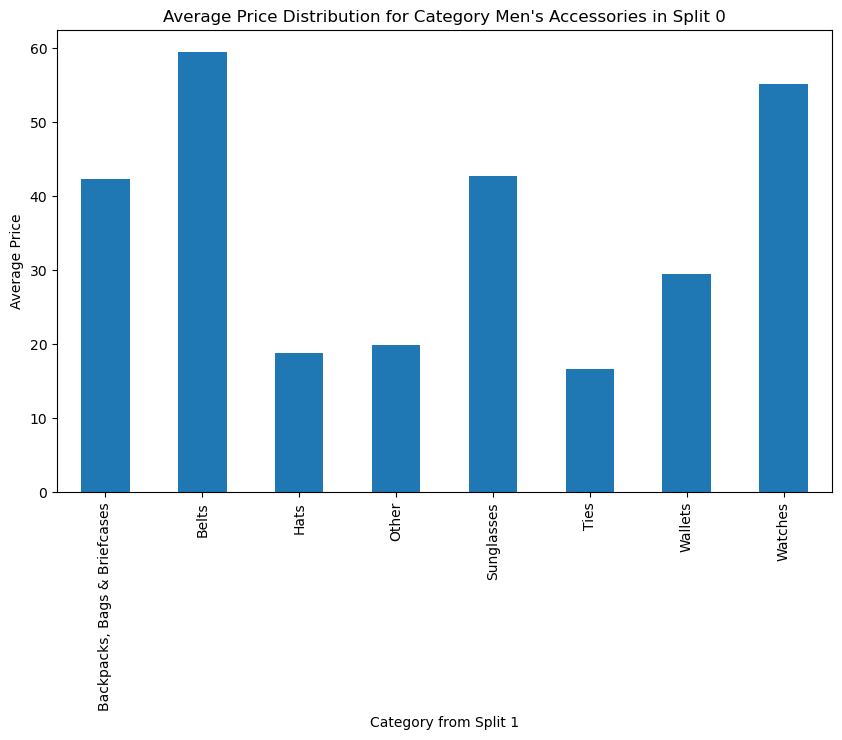

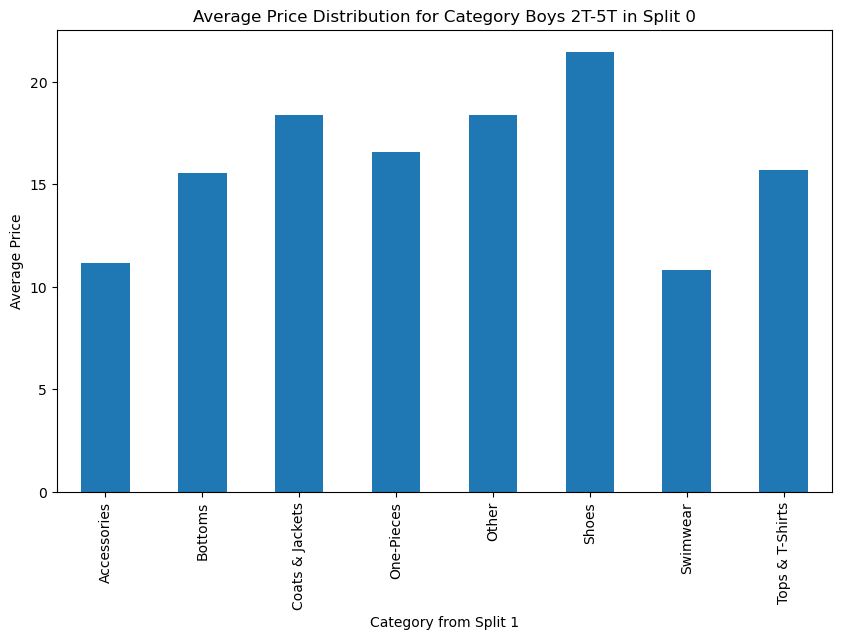

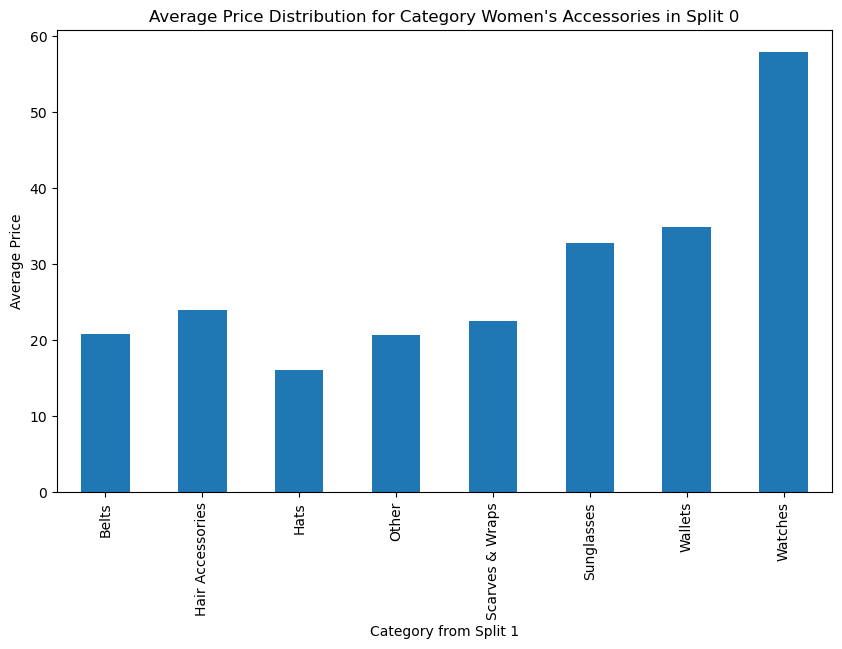

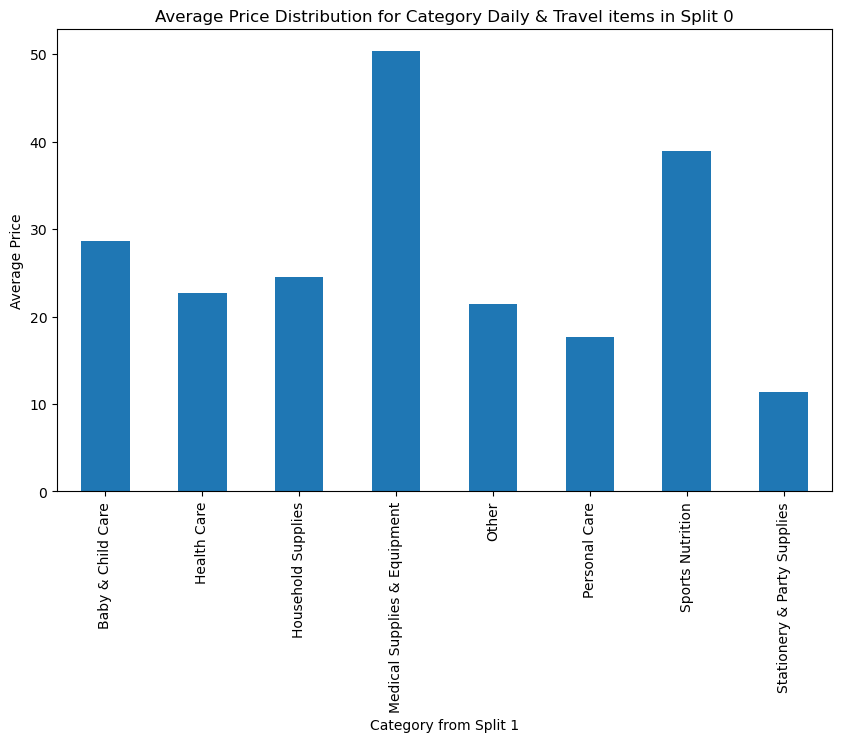

IndexError: index 0 is out of bounds for axis 0 with size 0

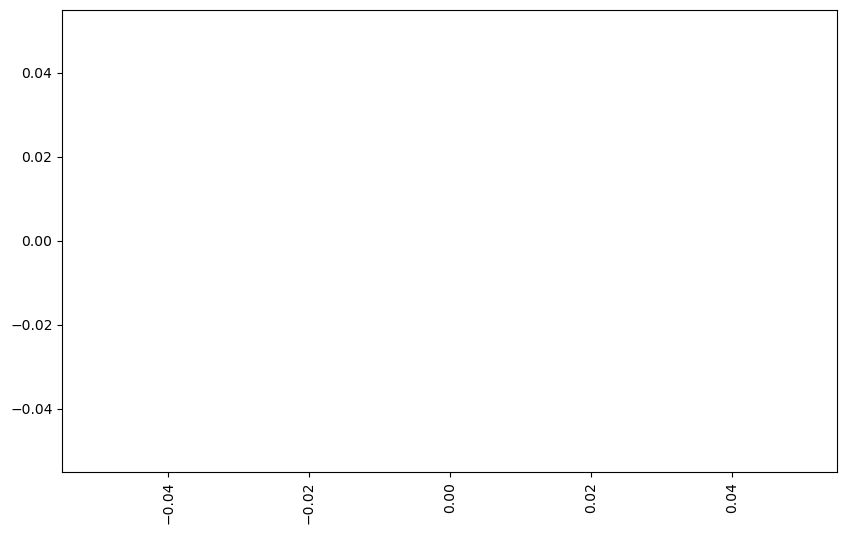

In [ ]:
unique_categories= merged_data[1].unique()
# Plot for each category in column '0'
for category in unique_categories:
    if category!= 'No Data':
        # Filter data for the current category
        filtered_data = merged_data[merged_data[1] == category]
        
        # Calculate the average price for each category in column '1'
        category_avg = filtered_data.groupby(2)['price'].mean()
        
        # Plotting
        plt.figure(figsize=(10, 6))
        category_avg.plot(kind='bar')
        plt.title(f'Average Price Distribution for Category {category} in Split 0')
        plt.xlabel('Category from Split 1')
        plt.ylabel('Average Price')
        plt.show()

Doing preprocessing


In [21]:
train['category_main'] = category_splits[0]
train['category_sub1'] = category_splits[1]
train['category_sub2'] = category_splits[2]

# Optional: Drop the original 'category_name' column if it's no longer needed
train.drop('category_name', axis=1, inplace=True)

train['category_name']=train['category_main'] + ' ' + train['category_sub1'] + ' ' + train['category_sub2']
display(train.head())

train_id                                 name  item_condition_id  \
0         0  MLB Cincinnati Reds T Shirt Size XL                  3   
1         1     Razer BlackWidow Chroma Keyboard                  3   
2         2                       AVA-VIV Blouse                  1   
3         3                Leather Horse Statues                  1   
4         4                 24K GOLD plated rose                  1   

  brand_name  price  shipping  \
0    Unknown   10.0         1   
1      Razer   52.0         0   
2     Target   10.0         1   
3    Unknown   35.0         1   
4    Unknown   44.0         0   

                                    item_description category_main  \
0                                 No description yet           Men   
1  This keyboard is in great condition and works ...   Electronics   
2  Adorable top with a hint of lace and a key hol...         Women   
3  New with tags. Leather horses. Retail for [rm]...          Home   
4          Complete with certificate of authenticity         Women   

         category_sub1       category_sub2  \
0                 Tops            T-shirts   
1  Computers & Tablets  Components & Parts   
2       Tops & Blouses              Blouse   
3           Home Décor  Home Décor Accents   
4              Jewelry           Necklaces   

                                       category_name  
0                                  Men Tops T-shirts  
1  Electronics Computers & Tablets Components & P...  
2                        Women Tops & Blouses Blouse  
3                 Home Home Décor Home Décor Accents  
4                            Women Jewelry Necklaces

In [22]:
from sklearn.feature_extraction.text import TfidfVectorizer

# Initialize vectorizer
vectorizer = TfidfVectorizer(max_features=500, stop_words='english')

# Combine 'name' and 'item_description' for more context
train['full_description'] = train['name'] + ' ' + train['item_description']

# Create a TF-IDF matrix of the combined text
tfidf_matrix = vectorizer.fit_transform(train['full_description'])

# Create a DataFrame for the TF-IDF matrix
tfidf_df = pd.DataFrame(tfidf_matrix.toarray(), columns=vectorizer.get_feature_names_out())

# Add category labels to the DataFrame
tfidf_df['category_name'] = train['category_name']


In [23]:
# Group by 'category_name' and calculate mean TF-IDF for category descriptor
category_profiles = tfidf_df.groupby('category_name').mean()

# Drop the 'category_name' from the main DataFrame now that we've profiled it
tfidf_df.drop('category_name', axis=1, inplace=True)


In [24]:
from sklearn.metrics.pairwise import cosine_similarity

# Ensure the indices of the DataFrame are correct
category_profiles = category_profiles.reset_index()
tfidf_df = tfidf_df.reset_index(drop=True)
train = train.reset_index(drop=True)

# Mapping categories to their profiles
category_to_profile = {category: category_profiles.loc[category_profiles['category_name'] == category].drop('category_name', axis=1).values.flatten()
                       for category in category_profiles['category_name']}

# Calculate cosine similarity for each item
def get_similarity(index):
    item_vector = tfidf_df.iloc[index].values.reshape(1, -1)
    category = train.at[index, 'category_name']
    category_vector = category_to_profile.get(category, np.zeros(item_vector.shape))
    if not np.any(category_vector):  # Handle cases where the category might not have a profile (all zeros vector)
        return 0
    return cosine_similarity(item_vector, category_vector.reshape(1, -1))[0][0]

train['category_similarity'] = [get_similarity(i) for i in range(len(train))]

In [25]:
display(train.head())

train_id                                 name  item_condition_id  \
0         0  MLB Cincinnati Reds T Shirt Size XL                  3   
1         1     Razer BlackWidow Chroma Keyboard                  3   
2         2                       AVA-VIV Blouse                  1   
3         3                Leather Horse Statues                  1   
4         4                 24K GOLD plated rose                  1   

  brand_name  price  shipping  \
0    Unknown   10.0         1   
1      Razer   52.0         0   
2     Target   10.0         1   
3    Unknown   35.0         1   
4    Unknown   44.0         0   

                                    item_description category_main  \
0                                 No description yet           Men   
1  This keyboard is in great condition and works ...   Electronics   
2  Adorable top with a hint of lace and a key hol...         Women   
3  New with tags. Leather horses. Retail for [rm]...          Home   
4          Complete with certificate of authenticity         Women   

         category_sub1       category_sub2  \
0                 Tops            T-shirts   
1  Computers & Tablets  Components & Parts   
2       Tops & Blouses              Blouse   
3           Home Décor  Home Décor Accents   
4              Jewelry           Necklaces   

                                       category_name  \
0                                  Men Tops T-shirts   
1  Electronics Computers & Tablets Components & P...   
2                        Women Tops & Blouses Blouse   
3                 Home Home Décor Home Décor Accents   
4                            Women Jewelry Necklaces   

                                    full_description  category_similarity  
0  MLB Cincinnati Reds T Shirt Size XL No descrip...             0.606835  
1  Razer BlackWidow Chroma Keyboard This keyboard...             0.403884  
2  AVA-VIV Blouse Adorable top with a hint of lac...             0.177566  
3  Leather Horse Statues New with tags. Leather h...             0.118837  
4  24K GOLD plated rose Complete with certificate...             0.145570

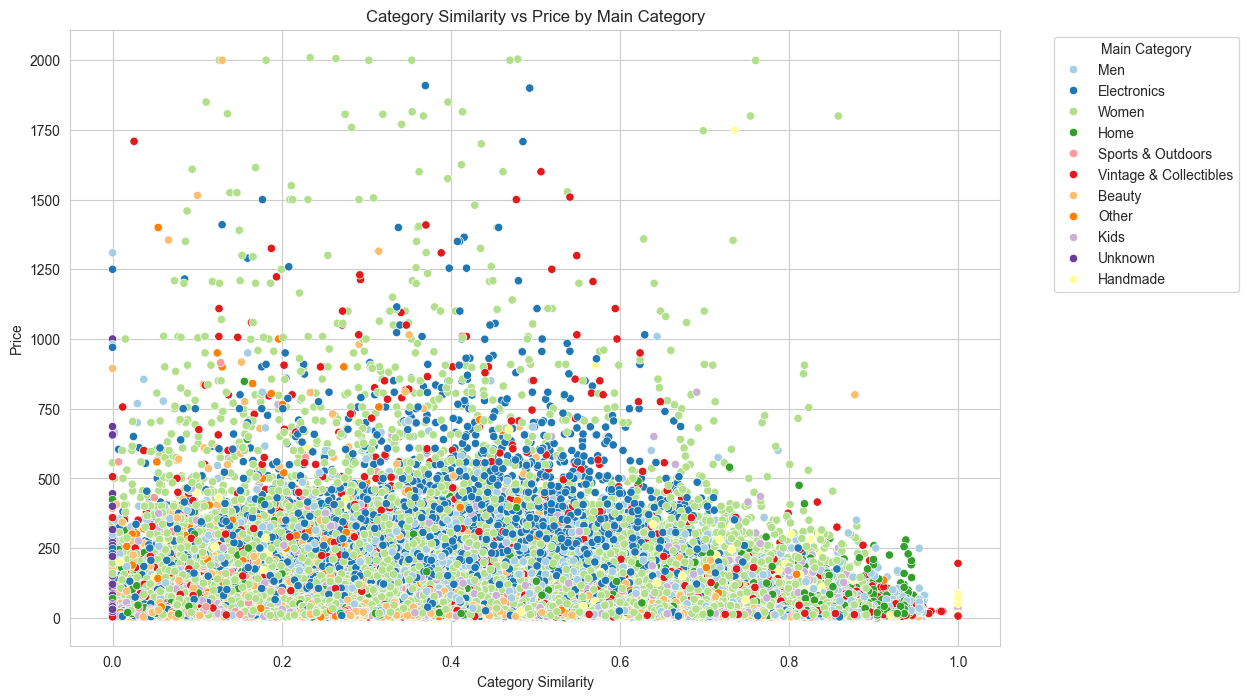

In [26]:
import seaborn as sns
sns.set_style("whitegrid")

# Create the plot
plt.figure(figsize=(12, 8))  # You can adjust the size as needed
scatter = sns.scatterplot(x='category_similarity', y='price', hue='category_main', palette='Paired', data=train)

plt.title('Category Similarity vs Price by Main Category')
plt.xlabel('Category Similarity')
plt.ylabel('Price')
plt.legend(title='Main Category', bbox_to_anchor=(1.05, 1), loc='upper left')  # Adjust legend position outside the plot

plt.show()

In [27]:
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import string

# Download necessary NLTK resources
nltk.download('stopwords')
nltk.download('wordnet')

# Initialize lemmatizer
lemmatizer = WordNetLemmatizer()

# Stopwords list
stop_words = set(stopwords.words('english'))

def clean_text(text):
    text = text.replace('/', ' or ')
    # Convert text to lowercase
    text = text.lower()
    # Remove punctuation
    text = text.translate(str.maketrans('', '', string.punctuation))
    # Remove stopwords and lemmatize
    text = ' '.join([lemmatizer.lemmatize(word) for word in text.split() if word not in stop_words])
    return text


train['full_description'] = train['full_description'].apply(clean_text)


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\divya\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\divya\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [ ]:
# train.to_csv('C:/Users/divya/OneDrive/Documents/UTAUSTIN/Semester 6/461p/ECE-461P-Term-Project/mercari-price-suggestion-challenge/train_features.csv', index=False)


In [3]:
display(train.head())

train_id                                 name  item_condition_id  \
0         0  MLB Cincinnati Reds T Shirt Size XL                  3   
1         1     Razer BlackWidow Chroma Keyboard                  3   
2         2                       AVA-VIV Blouse                  1   
3         3                Leather Horse Statues                  1   
4         4                 24K GOLD plated rose                  1   

                                       category_name brand_name  price  \
0                                  Men/Tops/T-shirts        NaN   10.0   
1  Electronics/Computers & Tablets/Components & P...      Razer   52.0   
2                        Women/Tops & Blouses/Blouse     Target   10.0   
3                 Home/Home Décor/Home Décor Accents        NaN   35.0   
4                            Women/Jewelry/Necklaces        NaN   44.0   

   shipping                                   item_description  
0         1                                 No description yet  
1         0  This keyboard is in great condition and works ...  
2         1  Adorable top with a hint of lace and a key hol...  
3         1  New with tags. Leather horses. Retail for [rm]...  
4         0          Complete with certificate of authenticity

In [4]:
train=pd.read_csv('C:/Users/divya/OneDrive/Documents/UTAUSTIN/Semester 6/461p/ECE-461P-Term-Project/mercari-price-suggestion-challenge/train_features.csv' ,delimiter=',')



In [5]:
display(train.head())

train_id                                 name  item_condition_id  \
0         0  MLB Cincinnati Reds T Shirt Size XL                  3   
1         1     Razer BlackWidow Chroma Keyboard                  3   
2         2                       AVA-VIV Blouse                  1   
3         3                Leather Horse Statues                  1   
4         4                 24K GOLD plated rose                  1   

  brand_name  price  shipping  \
0    Unknown   10.0         1   
1      Razer   52.0         0   
2     Target   10.0         1   
3    Unknown   35.0         1   
4    Unknown   44.0         0   

                                    item_description category_main  \
0                                 No description yet           Men   
1  This keyboard is in great condition and works ...   Electronics   
2  Adorable top with a hint of lace and a key hol...         Women   
3  New with tags. Leather horses. Retail for [rm]...          Home   
4          Complete with certificate of authenticity         Women   

         category_sub1       category_sub2  \
0                 Tops            T-shirts   
1  Computers & Tablets  Components & Parts   
2       Tops & Blouses              Blouse   
3           Home Décor  Home Décor Accents   
4              Jewelry           Necklaces   

                                       category_name  \
0                                  Men Tops T-shirts   
1  Electronics Computers & Tablets Components & P...   
2                        Women Tops & Blouses Blouse   
3                 Home Home Décor Home Décor Accents   
4                            Women Jewelry Necklaces   

                                    full_description  category_similarity  
0   mlb cincinnati red shirt size xl description yet             0.606835  
1  razer blackwidow chroma keyboard keyboard grea...             0.403884  
2  avaviv blouse adorable top hint lace key hole ...             0.177566  
3  leather horse statue new tag leather horse ret...             0.118837  
4  24k gold plated rose complete certificate auth...             0.145570

In [6]:
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [7]:
import os

max_workers = os.cpu_count()  # Gets the number of cores in your machine

print(max_workers)

20


In [8]:
from torch.utils.data import DataLoader, Dataset
import torch
from transformers import DistilBertTokenizer, DistilBertModel
import numpy as np

class TextDataset(Dataset):
    def __init__(self, texts, tokenizer, max_len=256):
        self.tokenizer = tokenizer
        self.texts = texts
        self.max_len = max_len
    
    def __len__(self):
        return len(self.texts)
    
    def __getitem__(self, idx):
        text = str(self.texts[idx])
        inputs = self.tokenizer.encode_plus(
            text,
            None,
            add_special_tokens=True,
            max_length=self.max_len,
            padding='max_length',
            truncation=True,
            return_attention_mask=True
        )
        return {
            'ids': torch.tensor(inputs['input_ids'], dtype=torch.long),
            'mask': torch.tensor(inputs['attention_mask'], dtype=torch.long)
        }

# Initialize the tokenizer and model
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')
model = DistilBertModel.from_pretrained('distilbert-base-uncased')

# Check for GPU availability and set the device accordingly
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)  # Move model to the selected device
print("Device used:", device)

# Create dataset and dataloader
dataset = TextDataset(train['full_description'].tolist(), tokenizer)
loader = DataLoader(dataset, batch_size=100, num_workers=20, pin_memory=True) 



Device used: cuda


In [9]:

def encode_batch(loader):
    model.eval()
    description_vectors = []
    print("Started")
    for batch in loader:
        ids = batch['ids'].to(device)
        mask = batch['mask'].to(device)
        print("here is me")
        with torch.no_grad():
            outputs = model(input_ids=ids, attention_mask=mask)
        
        # Ensure to move the tensor to CPU before converting to numpy
        vectors = outputs.last_hidden_state[:, 0, :].detach().cpu().numpy()
        print(vectors)
        description_vectors.extend(vectors)
    
    return np.array(description_vectors)  # Convert list to numpy array for easier handling later

print("Starting encoding...")
# Encoding descriptions
description_vectors = encode_batch(loader)
train['description_vector'] = list(description_vectors)  # Store vectors in DataFrame
print("Encoding completed.")


Starting encoding...
Started


In [ ]:
from sklearn.preprocessing import OneHotEncoder

encoder = OneHotEncoder(sparse=False)
categorical_columns = ['brand_name', 'category_main', 'category_sub1', 'category_sub2']
categorical_data = encoder.fit_transform(train[categorical_columns])

# Convert numpy array to DataFrame
categorical_df = pd.DataFrame(categorical_data, columns=encoder.get_feature_names(categorical_columns))


In [ ]:
train['free_shipping'] = train['shipping'].apply(lambda x: 1 if x == 1 else 0)
train['no_free_shipping'] = train['shipping'].apply(lambda x: 1 if x == 0 else 0)


In [ ]:
# List all columns that should be kept
kept_columns = ['description_vector', 'free_shipping', 'no_free_shipping', 'category_similarity','description_vector']
kept_columns.extend(categorical_df.columns)

# Drop all other columns
train_final = pd.concat([train[kept_columns], categorical_df], axis=1)


In [ ]:
train_final.to_csv('C:/Users/divya/OneDrive/Documents/UTAUSTIN/Semester 6/461p/ECE-461P-Term-Project/mercari-price-suggestion-challenge/train_features_elfinal.csv' ,delimiter=',')
train_final=pd.read_csv('C:/Users/divya/OneDrive/Documents/UTAUSTIN/Semester 6/461p/ECE-461P-Term-Project/mercari-price-suggestion-challenge/train_features_elfinal.csv' ,delimiter=',')


neural network

In [ ]:
import torch
from torch.utils.data import DataLoader, TensorDataset

# Convert features and target variable to PyTorch tensors
X = torch.tensor(train_final.values, dtype=torch.float32)
y = torch.tensor(train['price'].values, dtype=torch.float32).view(-1, 1)

# Create a TensorDataset and DataLoader
dataset = TensorDataset(X, y)
batch_size = 64  # You can adjust the batch size
loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)


In [ ]:
import torch.nn as nn
import torch.nn.functional as F

class ComplexNet(nn.Module):
    def __init__(self, input_size, output_size):
        super(ComplexNet, self).__init__()
        self.layer1 = nn.Linear(input_size, 512)
        self.bn1 = nn.BatchNorm1d(512)
        self.dropout1 = nn.Dropout(0.3)
        
        self.layer2 = nn.Linear(512, 256)
        self.bn2 = nn.BatchNorm1d(256)
        self.dropout2 = nn.Dropout(0.2)
        
        self.layer3 = nn.Linear(256, 128)
        self.bn3 = nn.BatchNorm1d(128)
        self.dropout3 = nn.Dropout(0.1)
        
        self.output_layer = nn.Linear(128, output_size)
        
    def forward(self, x):
        x = F.relu(self.bn1(self.layer1(x)))
        x = self.dropout1(x)
        x = F.relu(self.bn2(self.layer2(x)))
        x = self.dropout2(x)
        x = F.relu(self.bn3(self.layer3(x)))
        x = self.dropout3(x)
        x = self.output_layer(x)
        return x

# Initialize the model
input_size = train_final.shape[1]  # Number of features
output_size = 1  # Single value output for regression
model = ComplexNet(input_size, output_size)


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)


In [ ]:
import torch.optim as optim

criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)


In [ ]:

model.train()
for epoch in range(50): #number of epochs
    for inputs, targets in loader:
        inputs, targets = inputs.to(device), targets.to(device)
        
        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        
        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    
    print(f'Epoch [{epoch+1}/{50}], Loss: {loss.item():.4f}')


In [ ]:
def rmsle(y_true, y_pred):
    """
    Calculates the Root Mean Squared Logarithmic Error between true and predicted values.
    Args:
    y_true (torch.Tensor): True values.
    y_pred (torch.Tensor): Predictions.
    
    Returns:
    torch.Tensor: RMSLE score.
    """
    # Add 1 to both arrays to avoid taking log of zero
    log_true = torch.log(y_true + 1)
    log_pred = torch.log(y_pred + 1)
    squared_log_error = (log_true - log_pred) ** 2
    mean_squared_log_error = torch.mean(squared_log_error)
    return torch.sqrt(mean_squared_log_error)


In [ ]:
def evaluate(model, data_loader, criterion, device):
    model.eval()  # Set the model to evaluation mode
    total_loss = 0.0
    for inputs, targets in data_loader:
        inputs, targets = inputs.to(device), targets.to(device)
        with torch.no_grad():
            outputs = model(inputs)
            loss = criterion(targets, outputs)
        total_loss += loss.item() * inputs.size(0)
    avg_loss = total_loss / len(data_loader.dataset)
    return avg_loss

# Calculate RMSLE on the training data
train_rmsle = evaluate(model, loader, rmsle, device)
print(f'Training RMSLE: {train_rmsle:.4f}')


In [ ]:
# Assuming you have a test_loader set up similar to train_loader
#test_loader is to do
test_rmsle = evaluate(model, test_loader, rmsle, device)
print(f'Test RMSLE: {test_rmsle:.4f}')
